In [4]:
import os
import gzip
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import statsmodels.api as sm
import sklearn.preprocessing
import scipy.sparse
import sklearn.metrics
import sklearn.mixture
import sklearn.linear_model
import scipy.stats as stats
from anndata import AnnData
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import psutil
import os
import matplotlib as mpl
from matplotlib import cm
import gc

sc.settings.set_figure_params(dpi=100)
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
%load_ext rpy2.ipython

sns.set(font_scale=1.5)
plt.style.use('seaborn-white')

#sc.logging.print_versions()

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Download data

In [1]:
########### download raw data
### Download 10x snATAC-seq raw data from NCBI Gene Expression Omnibus (GSE169453)
### Download 10x multiome raw data from NCBI Gene Expression Omnibus (GSE200044)

########### Download processed snATAC-seq and multiome data to reproduce figures
### There several ways to download processed data.
###1, download files less than 25M from github data folder: https://github.com/gaoweiwang/Islet_snATACseq
### or, from figshare:
### multiome: https://figshare.com/articles/dataset/processed_multiome_zip/19497665
### snATACseq: https://figshare.com/articles/dataset/processed_snATACseq_zip/19497656

###2, download large processed or intermeidate files:
#snATAC-seq data (http://169.228.232.194/~mmallick/o/processed_snATACseq.tar.gz)
#multiome data (http://169.228.232.194/~mmallick/o/processed_multiome.tar.gz)


# snATAC-seq cell cluster in Figure 1b and Supplementary Figure 1

In [5]:
wd_snATAC = '/oasis/tscc/scratch/gaw006/snATACseq/processed/'
wd_multiome = '/oasis/tscc/scratch/gaw006/multiome/processed/'

## load final snATAC-seq UMAP
### cell_cluster_pipeline.ipynb is the pipeline to cluster cells
adata_norm=sc.read(wd_snATAC + 'snATAC_all_final.h5ad')
adata_norm.uns['leiden_colors']=['#CD0000','#008B45','#7FFFD4','#C1FFC1','#FFB5C5','#9AFF9A','#FFB90F','#C1CDCD','#FF82AB','#CDCD00','#CD69C9','#BFEFFF','#1C86EE','#6E7B8B']

## load cell-by-peak matrix
adata_merged=sc.read(wd_snATAC + 'snATAC_all_5kb_raw.h5ad')
adata_norm.obs['frac_reads_in_peaks']=adata_merged.obs['frac_reads_in_peaks']
adata_norm.obs['frac_reads_in_promoters']=adata_merged.obs['frac_reads_in_promoters']
adata_norm.obs['frac_mito_reads']=adata_merged.obs['frac_mito_reads']


/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


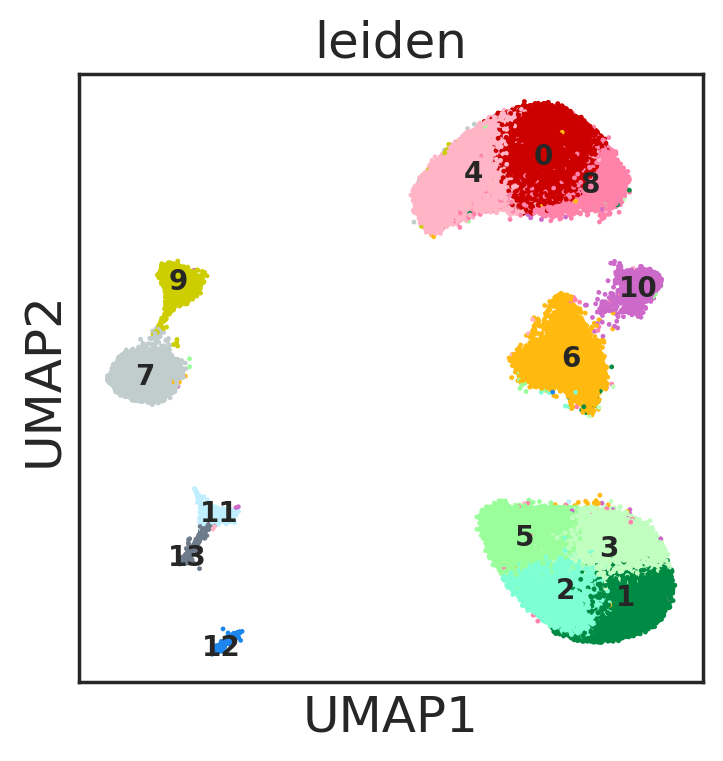

leiden
0     51967
1     26030
2     25582
3     24658
4     23214
5     16510
6     15143
7     12643
8      8282
9      5744
10     4811
11     1892
12     1374
13     1123
Name: leiden, dtype: int64

In [6]:
sc.pl.umap(adata_norm, color=['leiden'], size=12,color_map='Blues',legend_loc='on data',legend_fontsize=10)
adata_norm.obs.groupby('leiden')['leiden'].count()

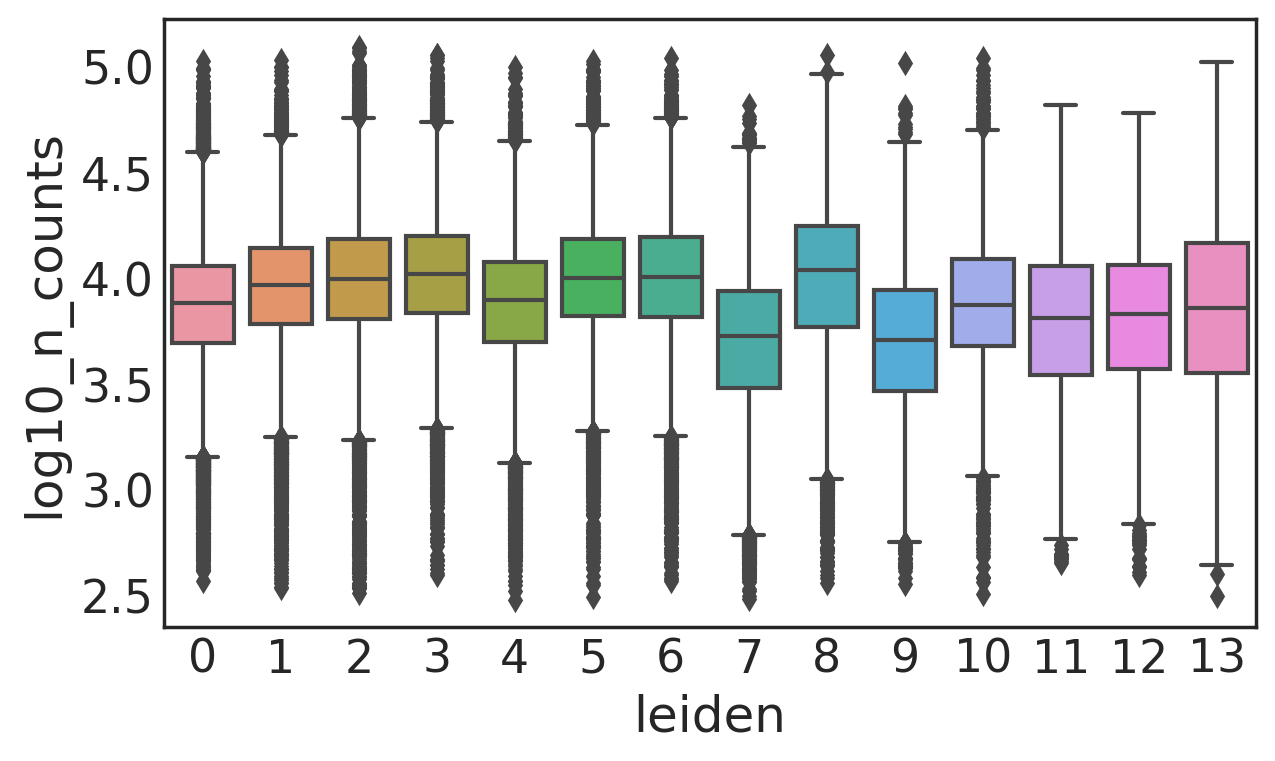

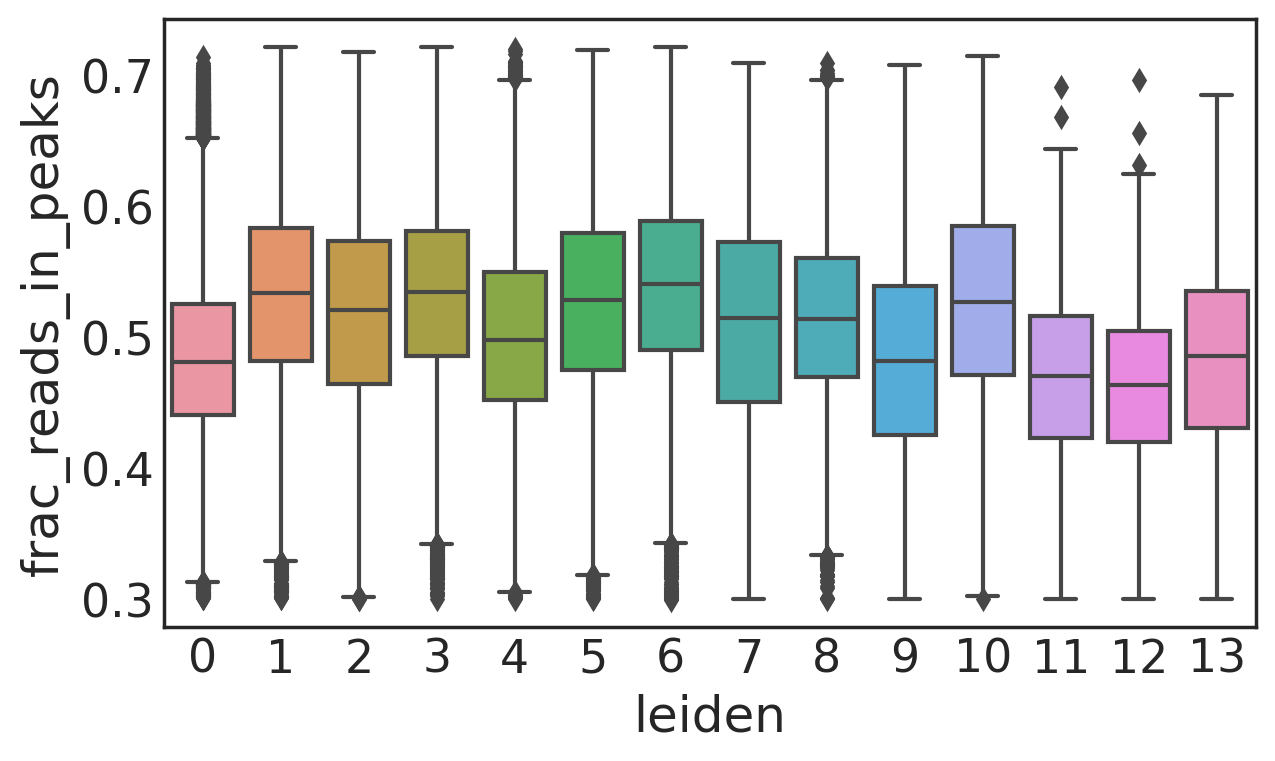

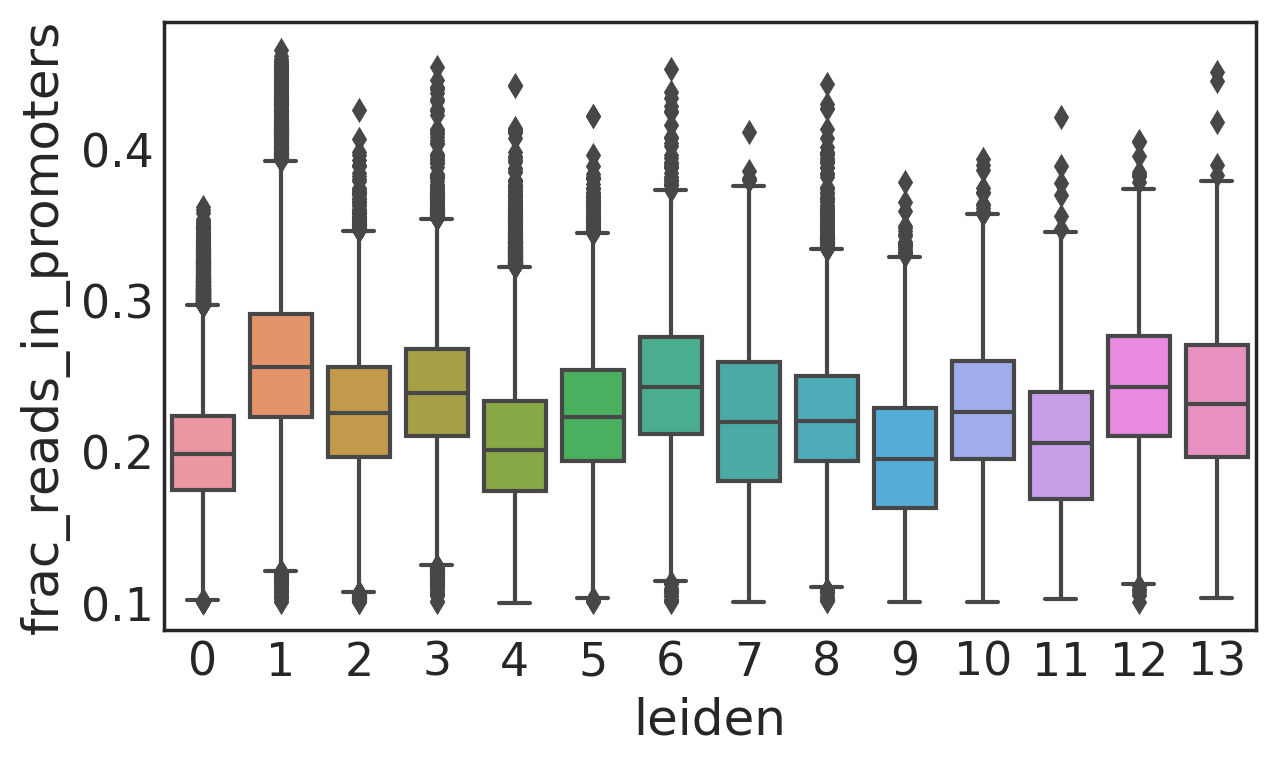

In [7]:
fig, ax1 = plt.subplots(1,1,figsize=(7,4))
sns.boxplot(x='leiden', y='log10_n_counts', data=adata_norm.obs)
plt.show()
#fig.savefig('/projects/sanderlab/gaowei/JP_notebook/figures/promoter.pdf')
fig, ax1 = plt.subplots(1,1,figsize=(7,4))
sns.boxplot(x='leiden', y='frac_reads_in_peaks', data=adata_norm.obs)
plt.show()

fig, ax1 = plt.subplots(1,1,figsize=(7,4))
sns.boxplot(x='leiden', y='frac_reads_in_promoters', data=adata_norm.obs)
plt.show()

/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


True


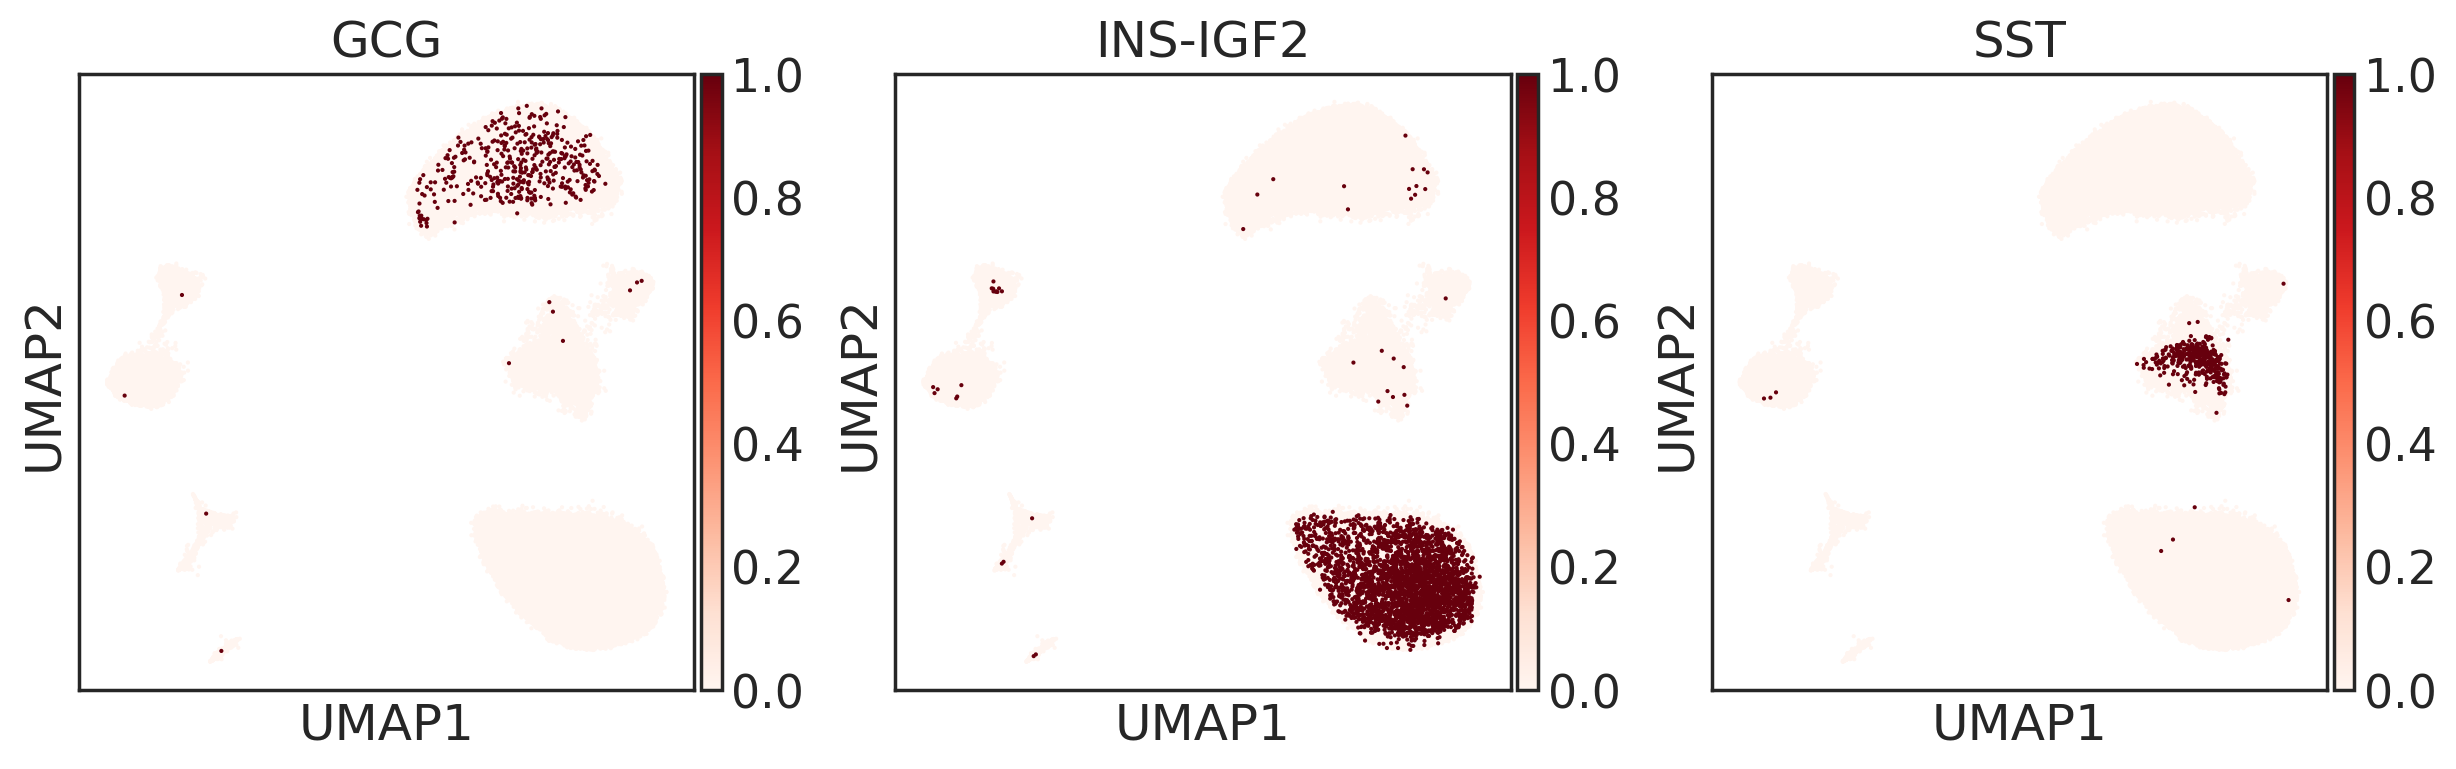

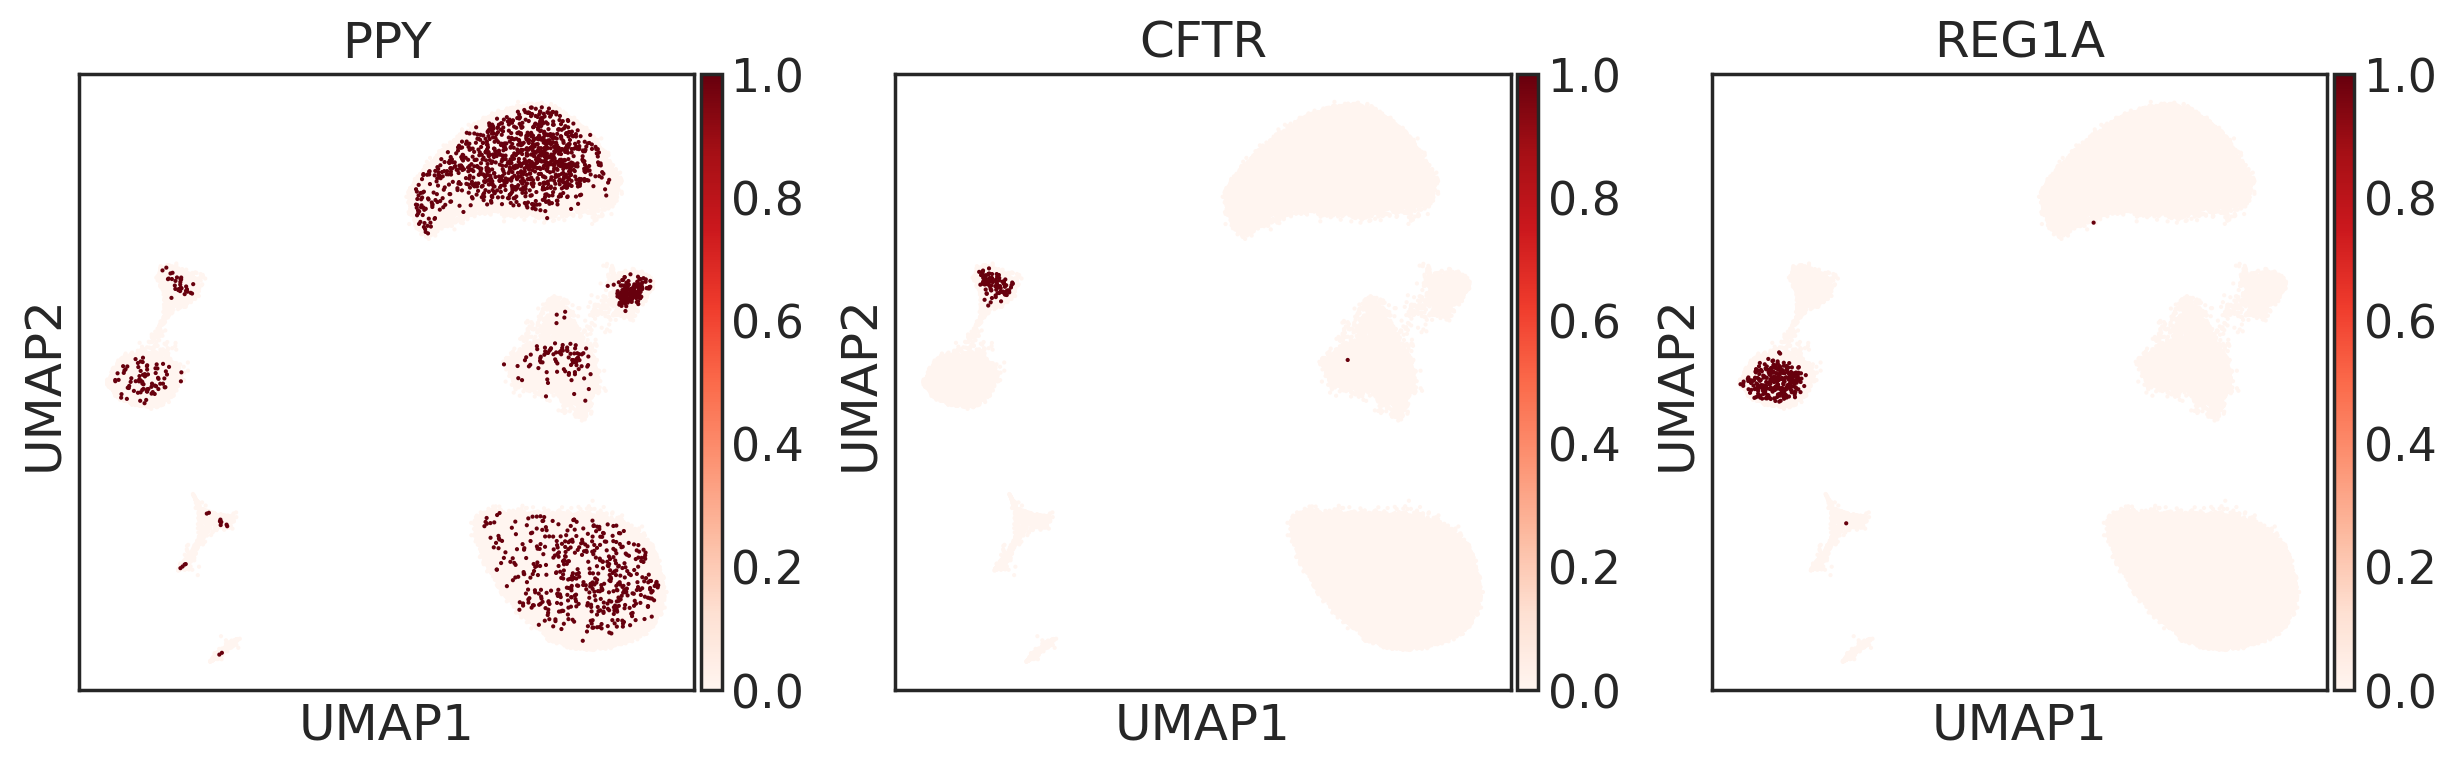

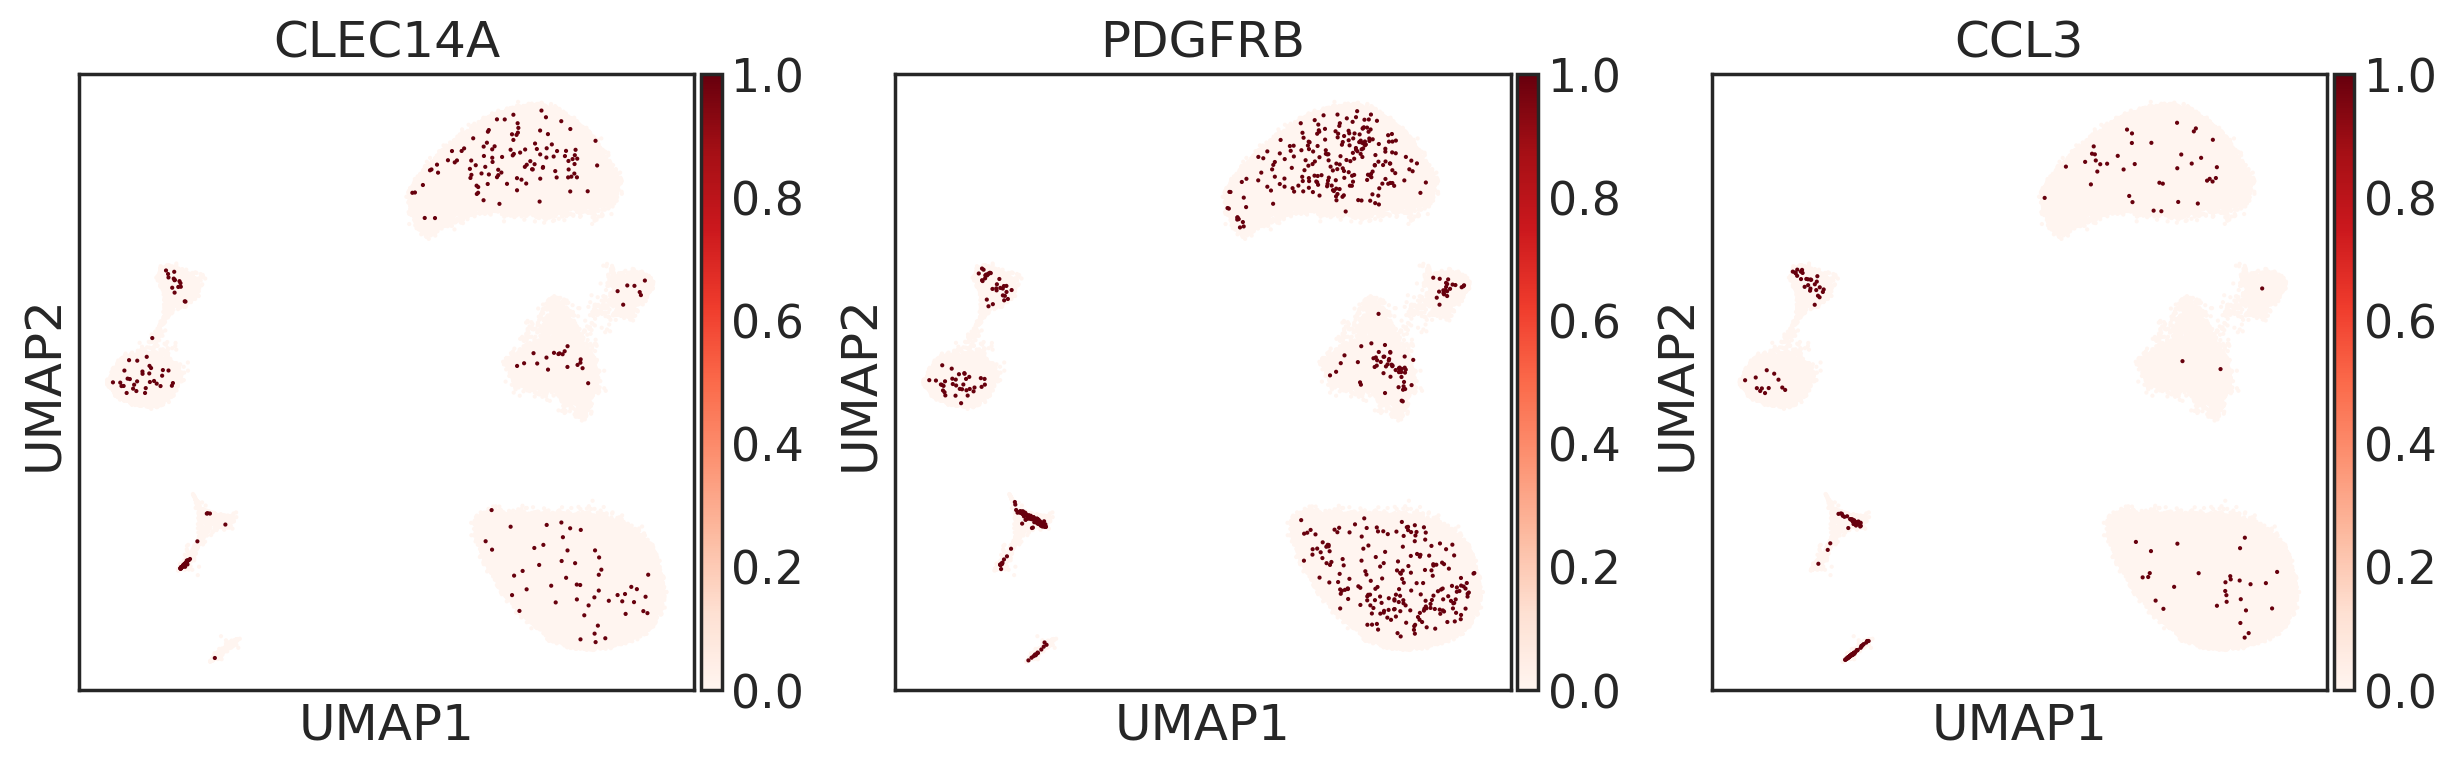

In [8]:
## plot marker genes
sc.pp.normalize_per_cell(adata_merged, counts_per_cell_after=1e4)
adata_merged.X= (adata_merged.X>2)
print(all(adata_norm.obs.index==adata_merged.obs.index))
adata_norm.raw=adata_merged

sc.pl.umap(adata_norm, color=['GCG','INS-IGF2','SST'], size=9, color_map='Reds', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['PPY','CFTR','REG1A'], size=9, color_map='Reds', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['CLEC14A','PDGFRB','CCL3'], size=9, color_map='Reds', frameon=True,use_raw=True)


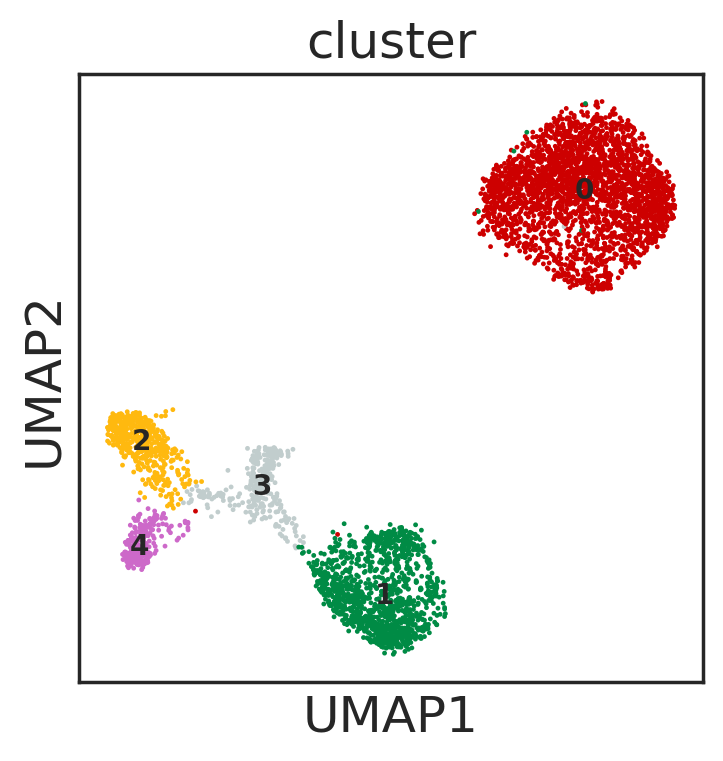

In [10]:
adata=sc.read(wd_snATAC + 'JYH809_final.h5ad')
adata.uns['cluster_colors']=['#CD0000','#008B45','#FFB90F','#C1CDCD','#CD69C9']

sc.pl.umap(adata, color=['cluster'], size=12,color_map='Blues',legend_loc='on data',legend_fontsize=10)


# snATAC-seq cell cluster of HPAP in Supplementary Figure 3

In [11]:
adata_merged=sc.read(wd_snATAC + 'HPAP_snATAC_raw.h5ad')
adata_norm=sc.read(wd_snATAC + 'HPAP_snATAC_final.h5ad')
sc.pp.normalize_per_cell(adata_merged, counts_per_cell_after=1e4)


/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


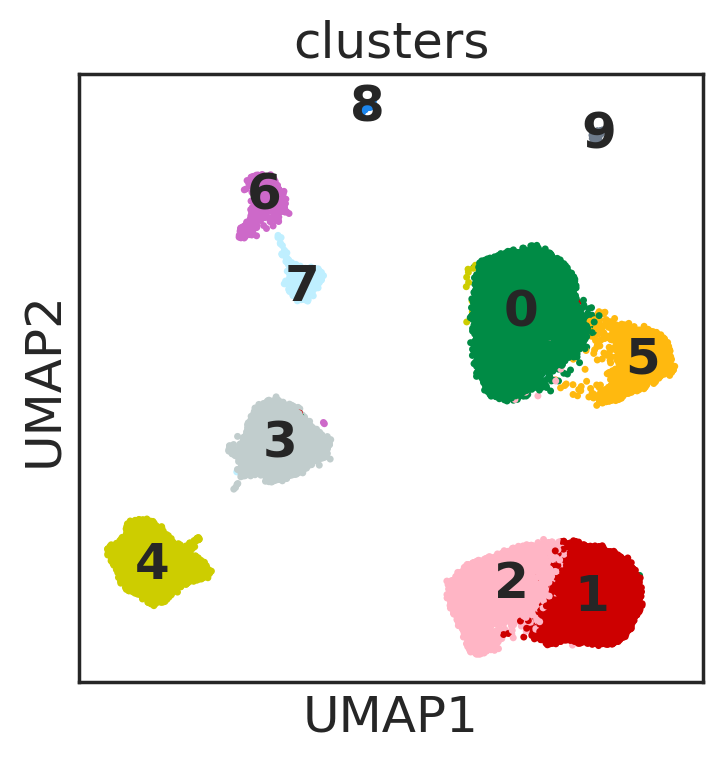

leiden
0    11588
1     9123
2     6022
3     5681
4     4504
5     2449
6     1217
7      751
8      192
9      165
Name: leiden, dtype: int64

In [12]:
adata_norm.obs['cluster']=adata_norm.obs['leiden']
adata_norm.uns['cluster_colors']=['#008B45','#CD0000','#FFB5C5','#C1CDCD','#CDCD00','#FFB90F','#CD69C9','#BFEFFF','#1C86EE','#6E7B8B']
sc.pl.umap(adata_norm, color=['cluster'], size=25, title='clusters', legend_loc='on data')
adata_norm.obs.groupby('leiden')['leiden'].count()


True


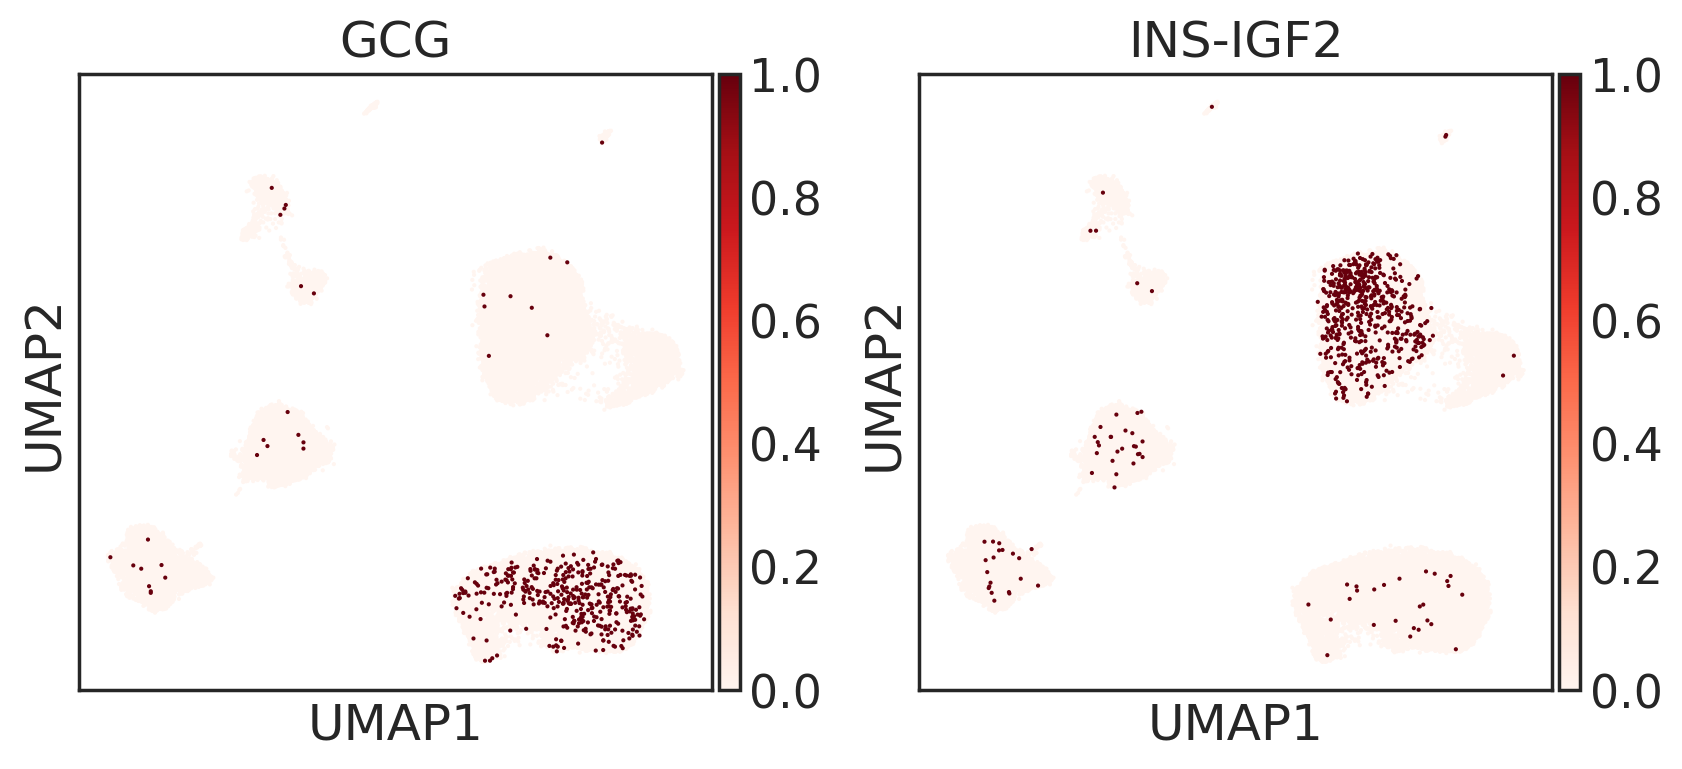

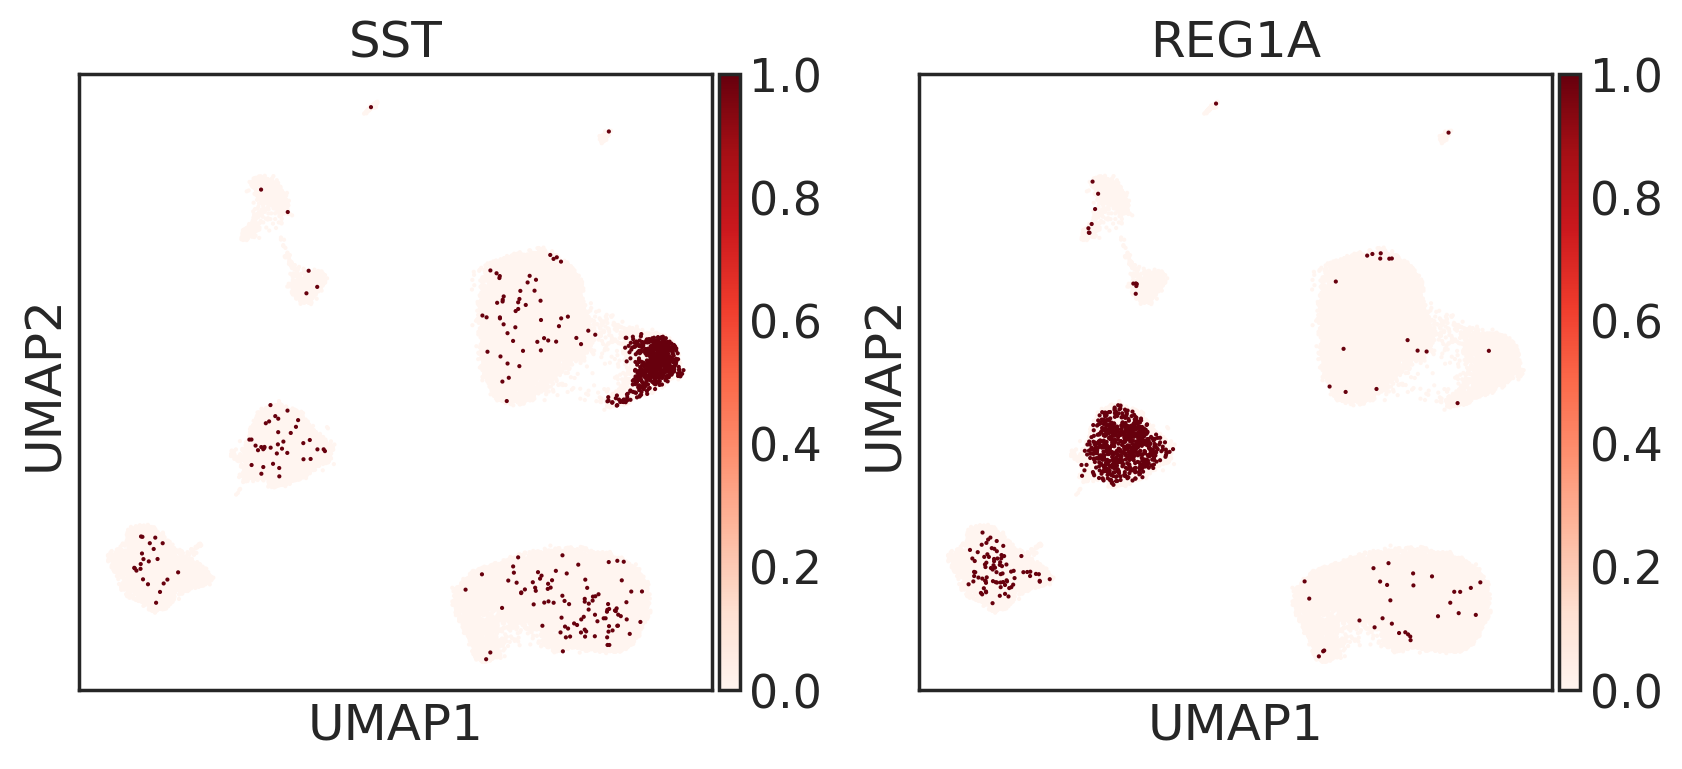

In [13]:
adata_merged.X= (adata_merged.X>1)
print(all(adata_norm.obs.index==adata_merged.obs.index))
adata_norm.raw=adata_merged

sc.pl.umap(adata_norm, color=['GCG','INS-IGF2'], size=9, color_map='Reds', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['SST','REG1A'], size=9, color_map='Reds', frameon=True,use_raw=True) 

# snATAC-seq cell cluster of beta cell in Supplementary Figure 5

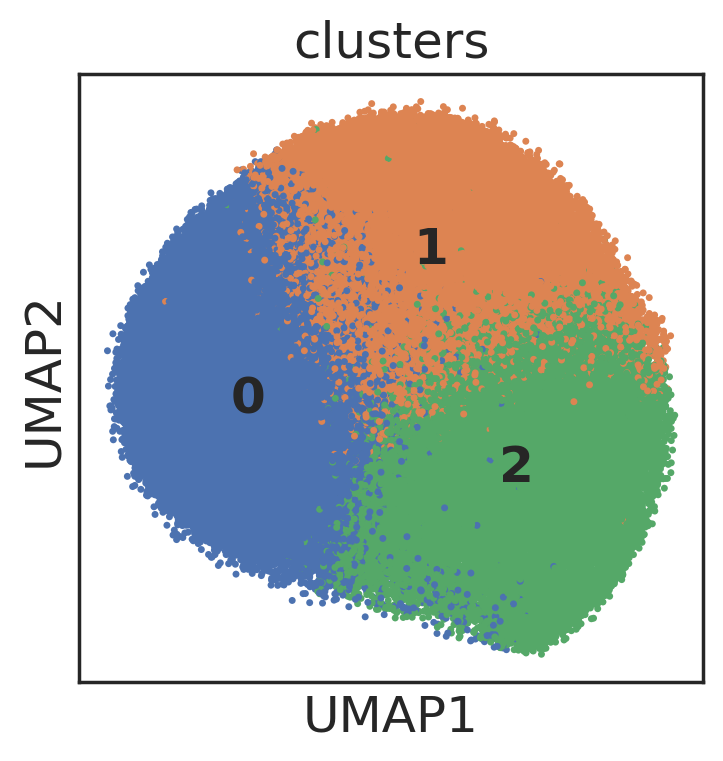

In [14]:
## all peaks
adata_norm=sc.read(wd_snATAC + 'snATAC_beta_final.h5ad')
adata_norm.obs['cluster']=adata_norm.obs['leiden']
sc.pl.umap(adata_norm, color=['cluster'], size=25, title='clusters', legend_loc='on data')


/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'donor' as categorical
... storing 'donor' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have pr

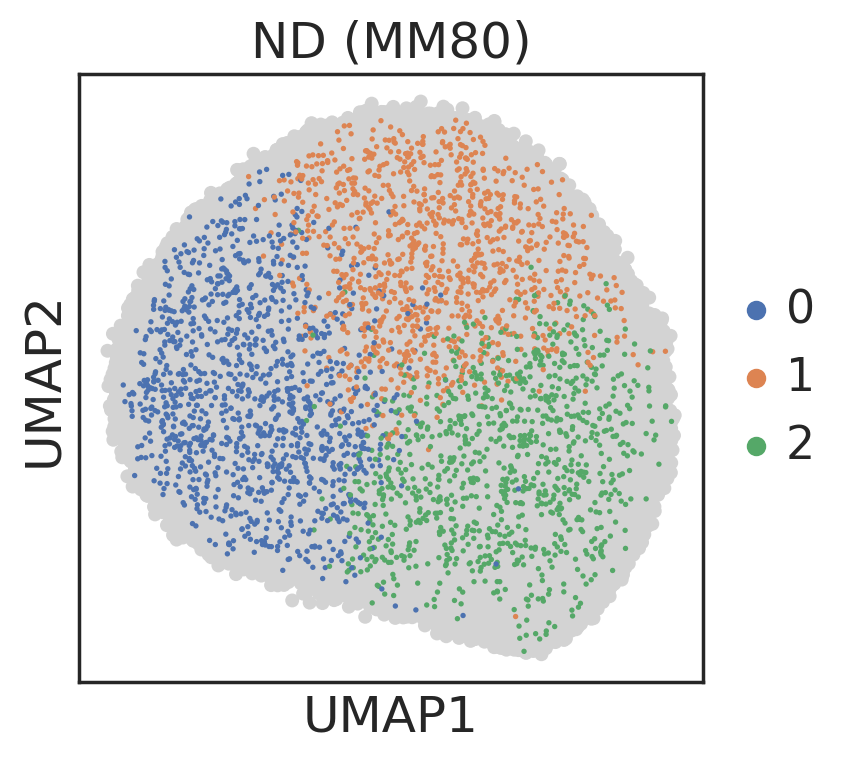

In [15]:
adata_norm.obs['donor'] = [i.split('_')[0] for i in adata_norm.obs.index]
adata_temp=adata_norm[adata_norm.obs['donor']=='MM80',:]
adata_temp
adata_temp.obs['cluster1']=adata_temp.obs['leiden']

ax = sc.pl.umap(adata_norm, size=100, show=False)
#temp_adata2.uns['dna_ident_colors']= ['#ff7f0e','#279e68','#d62728','#aa40fc','#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8','#ffbb78']

sc.pl.umap(adata_temp,color=['cluster1'], size=15, title='ND (MM80)',ax=ax)


Trying to set attribute `.obs` of view, copying.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all point

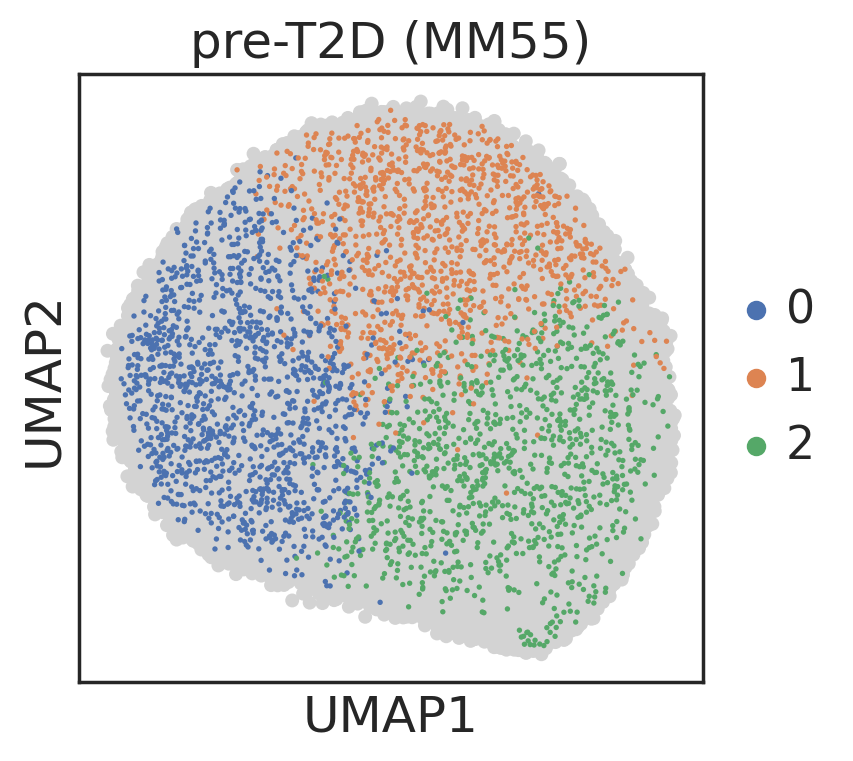

In [16]:
adata_temp=adata_norm[adata_norm.obs['donor']=='MM55',:]
adata_temp
adata_temp.obs['cluster1']=adata_temp.obs['leiden']

ax = sc.pl.umap(adata_norm, size=100, show=False)
#temp_adata2.uns['dna_ident_colors']= ['#ff7f0e','#279e68','#d62728','#aa40fc','#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8','#ffbb78']

sc.pl.umap(adata_temp,color=['cluster1'], size=15, title='pre-T2D (MM55)',ax=ax)


Trying to set attribute `.obs` of view, copying.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all point

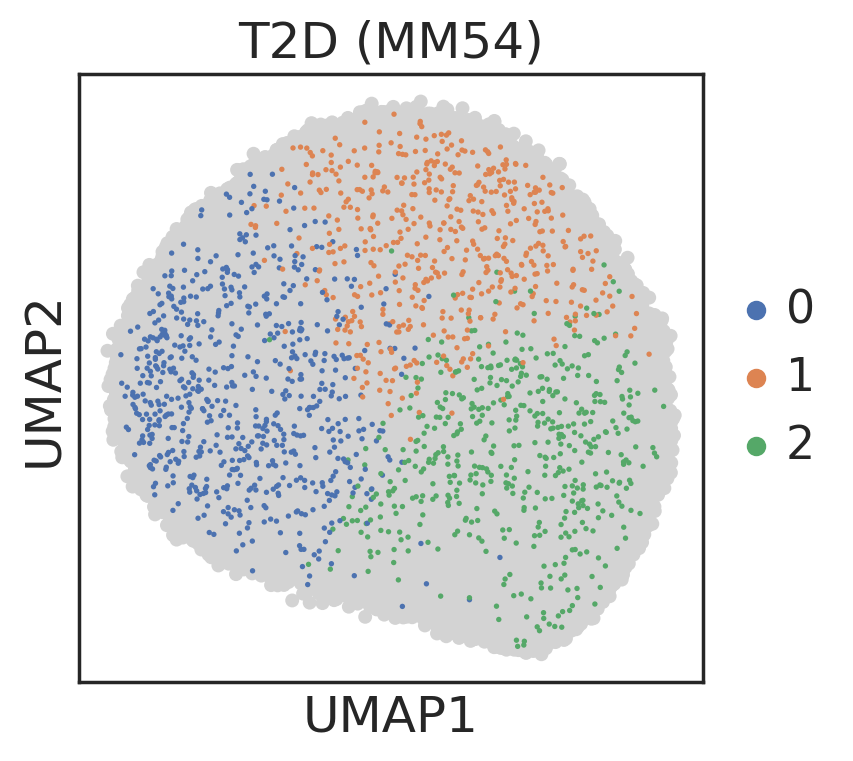

In [17]:
adata_temp=adata_norm[adata_norm.obs['donor']=='MM54',:]
adata_temp
adata_temp.obs['cluster1']=adata_temp.obs['leiden']

ax = sc.pl.umap(adata_norm, size=100, show=False)
#temp_adata2.uns['dna_ident_colors']= ['#ff7f0e','#279e68','#d62728','#aa40fc','#8c564b','#e377c2','#b5bd61','#17becf','#aec7e8','#ffbb78']

sc.pl.umap(adata_temp,color=['cluster1'], size=15, title='T2D (MM54)',ax=ax)


# beta cell cluster using differential peaks in Supplementary Figure 6

... storing 'donor' as categorical


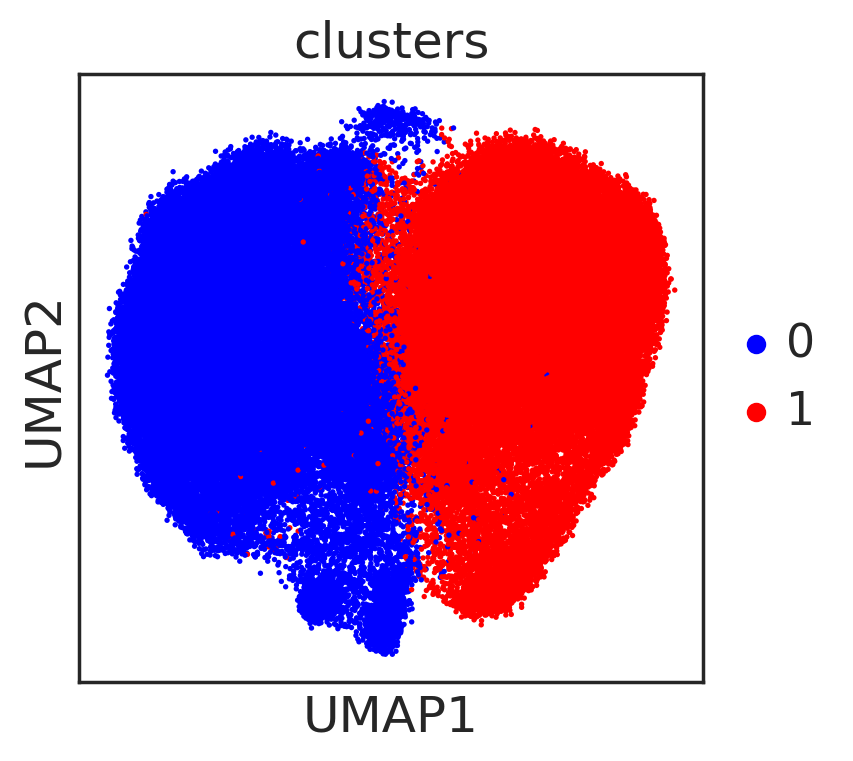

In [18]:
adata_all=sc.read(wd_snATAC + 'snATAC_beta_diff_final.h5ad')
adata_all.obs['cluster1']=adata_all.obs['leiden']
adata_all.obs['donor'] = [i.split('_')[0] for i in adata_all.obs.index]
adata_all.uns['cluster1_colors']=['#0000FF','#FF0000']
sc.pl.umap(adata_all,color=['cluster1'], size=15, title='clusters')


... storing 'donor' as categorical
... storing 'disease' as categorical
... storing 'disease1' as categorical


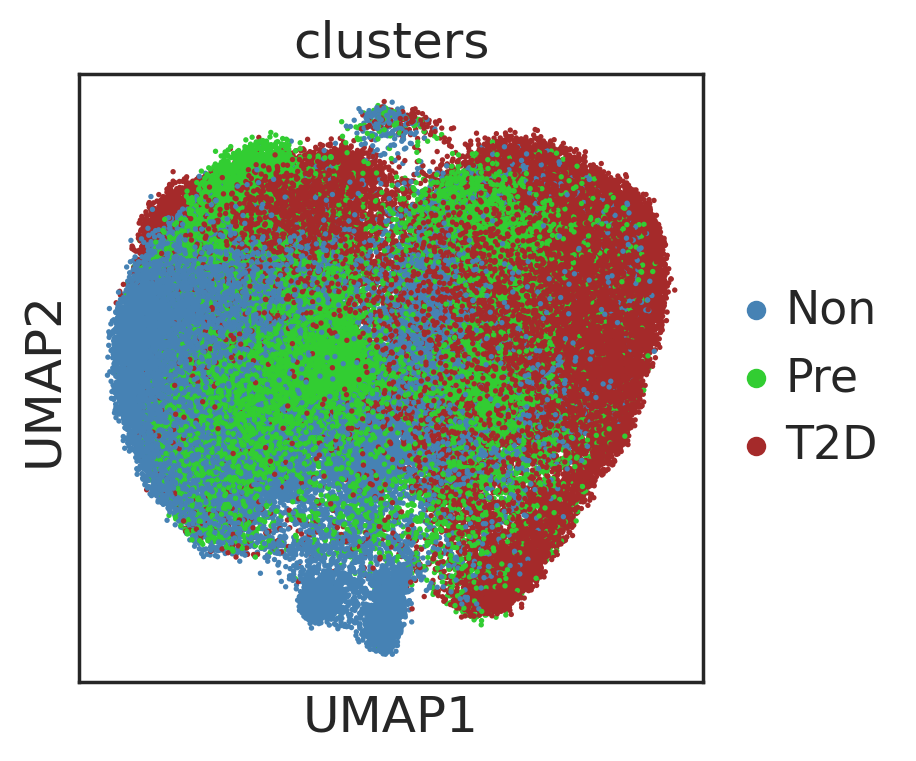

In [19]:
adata_all.obs['donor'] = [i.split('_')[0] for i in adata_all.obs.index]
samples_non = ['JYH792','MM56','MM59','MM80','MM86','MM89','MM95','MM98','MM110','MM123','MM124']
samples_pre = ['MM55','MM61','MM77','MM78','MM87','MM93','MM96','MM108']
samples_T2D = ['JYH809','MM12','MM51','MM54','MM57','MM60','MM79','MM81','MM88','MM94','MM97','MM109','MM120','MM121','MM122']

temp_disease = ['Non' if b in samples_non else b for b in adata_all.obs['donor']]
temp_disease = ['Pre' if b in samples_pre else b for b in temp_disease]
temp_disease = ['T2D' if b in samples_T2D else b for b in temp_disease]

adata_all.obs['disease'] = temp_disease
adata_all.obs['disease1']=adata_all.obs['disease']
#sc.pl.umap(adata_all, color=['disease1'], size=15, title='Final clusters')

adata_all.uns['disease1_colors']=['#4682B4','#32CD32','#A52A2A']
sc.pl.umap(adata_all,color=['disease1'], size=15, title='clusters')

Trying to set attribute `.uns` of view, copying.


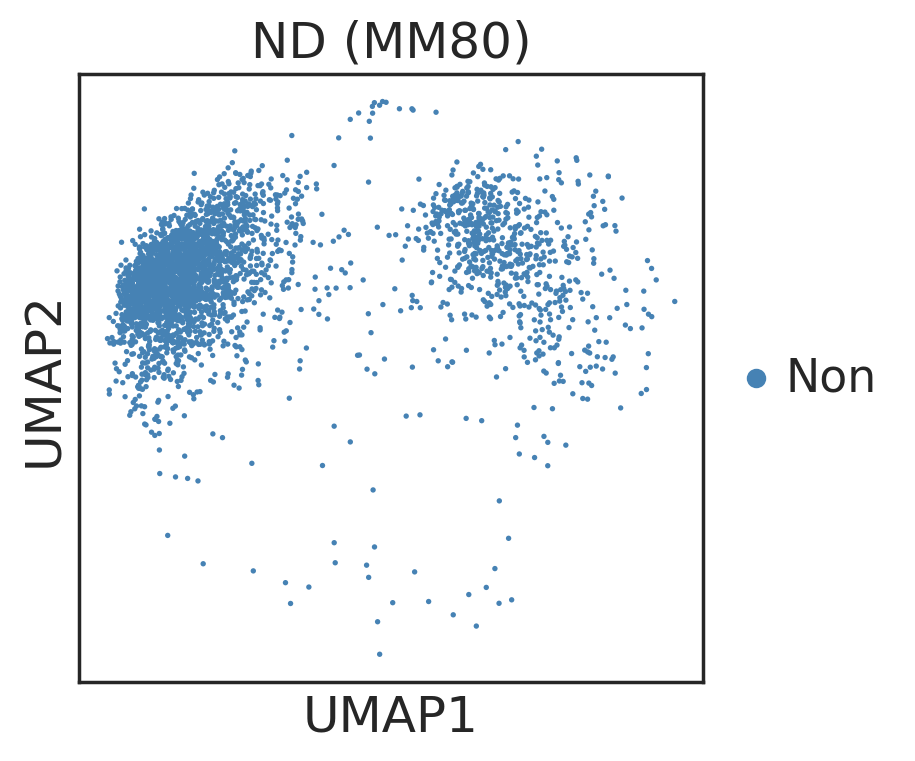

In [20]:
adata_temp=adata_all[adata_all.obs['donor']=='MM80',:]
adata_temp.uns['disease1_colors']=['#4682B4']
sc.pl.umap(adata_temp, color=['disease1'], size=15, title='ND (MM80)')


Trying to set attribute `.uns` of view, copying.


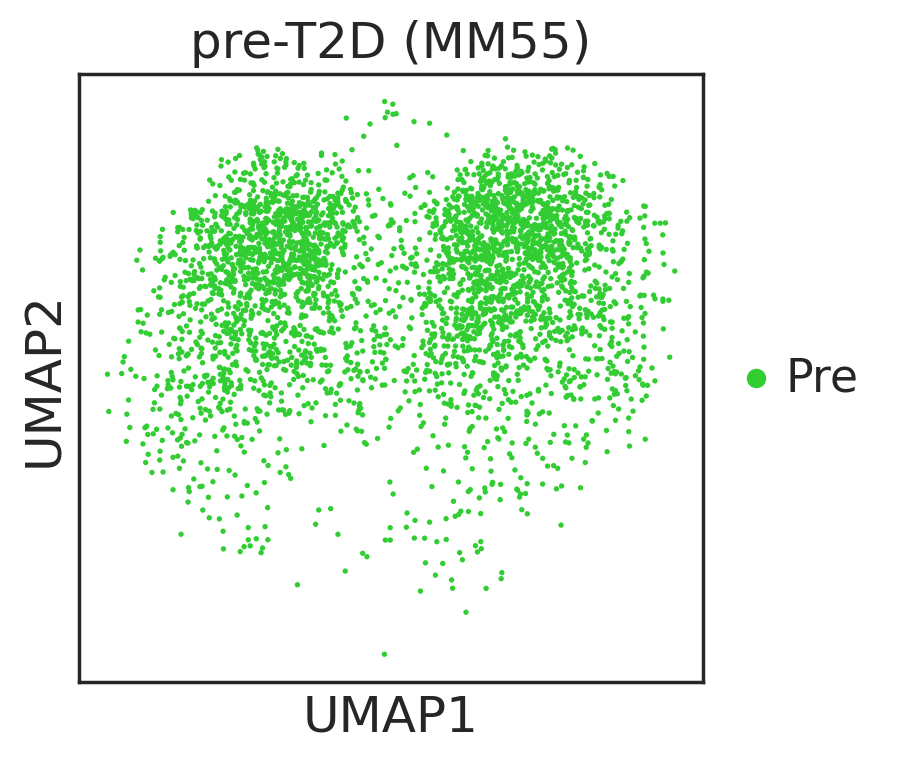

In [21]:
adata_temp=adata_all[adata_all.obs['donor']=='MM55',:]
adata_temp.uns['disease1_colors']=['#32CD32']
sc.pl.umap(adata_temp, color=['disease1'], size=15, title='pre-T2D (MM55)')

Trying to set attribute `.uns` of view, copying.


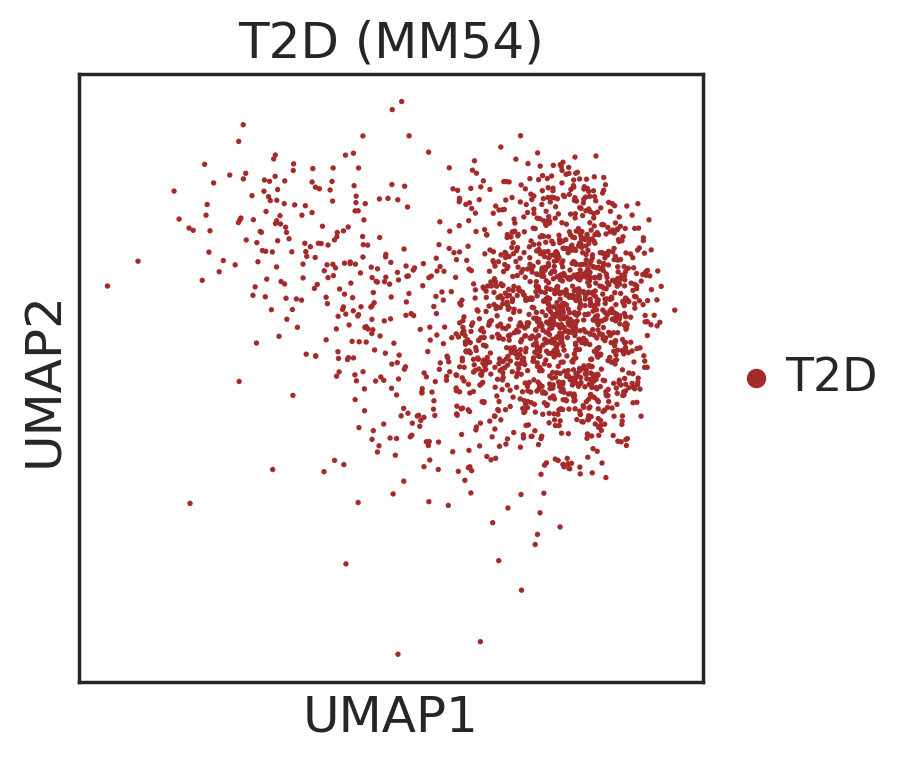

In [22]:
adata_temp=adata_all[adata_all.obs['donor']=='MM54',:]
adata_temp.uns['disease1_colors']=['#A52A2A']
sc.pl.umap(adata_temp, color=['disease1'], size=15, title='T2D (MM54)')

# multiome (ATAC and RNA) cell cluster in Supplementary Figure 7

True


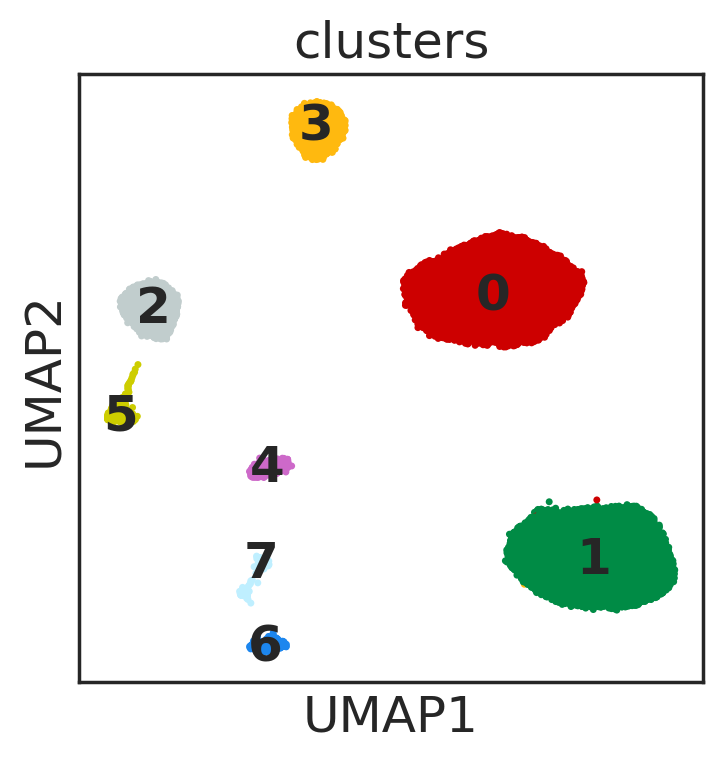

leiden
0    38298
1    33011
2     5474
3     4615
4     1331
5     1004
6      929
7      604
Name: leiden, dtype: int64

In [23]:
## ATAC (Supplementary Figure 7a)
adata_norm=sc.read(wd_multiome + 'multiome_ATAC_final.h5ad')
adata_ATAC=sc.read(wd_multiome + 'multiome_ATAC_raw.h5ad')
adata_norm.uns['leiden_colors']=['#CD0000','#008B45','#C1CDCD','#FFB90F','#CD69C9','#CDCD00','#1C86EE','#BFEFFF']

sc.pp.normalize_per_cell(adata_ATAC, counts_per_cell_after=1e4)
adata_ATAC.X= (adata_ATAC.X>1)
print(all(adata_norm.obs.index==adata_ATAC.obs.index))
adata_norm.raw=adata_ATAC

sc.pl.umap(adata_norm, color=['leiden'], size=25, title='clusters', legend_loc='on data')
adata_norm.obs.groupby('leiden')['leiden'].count()

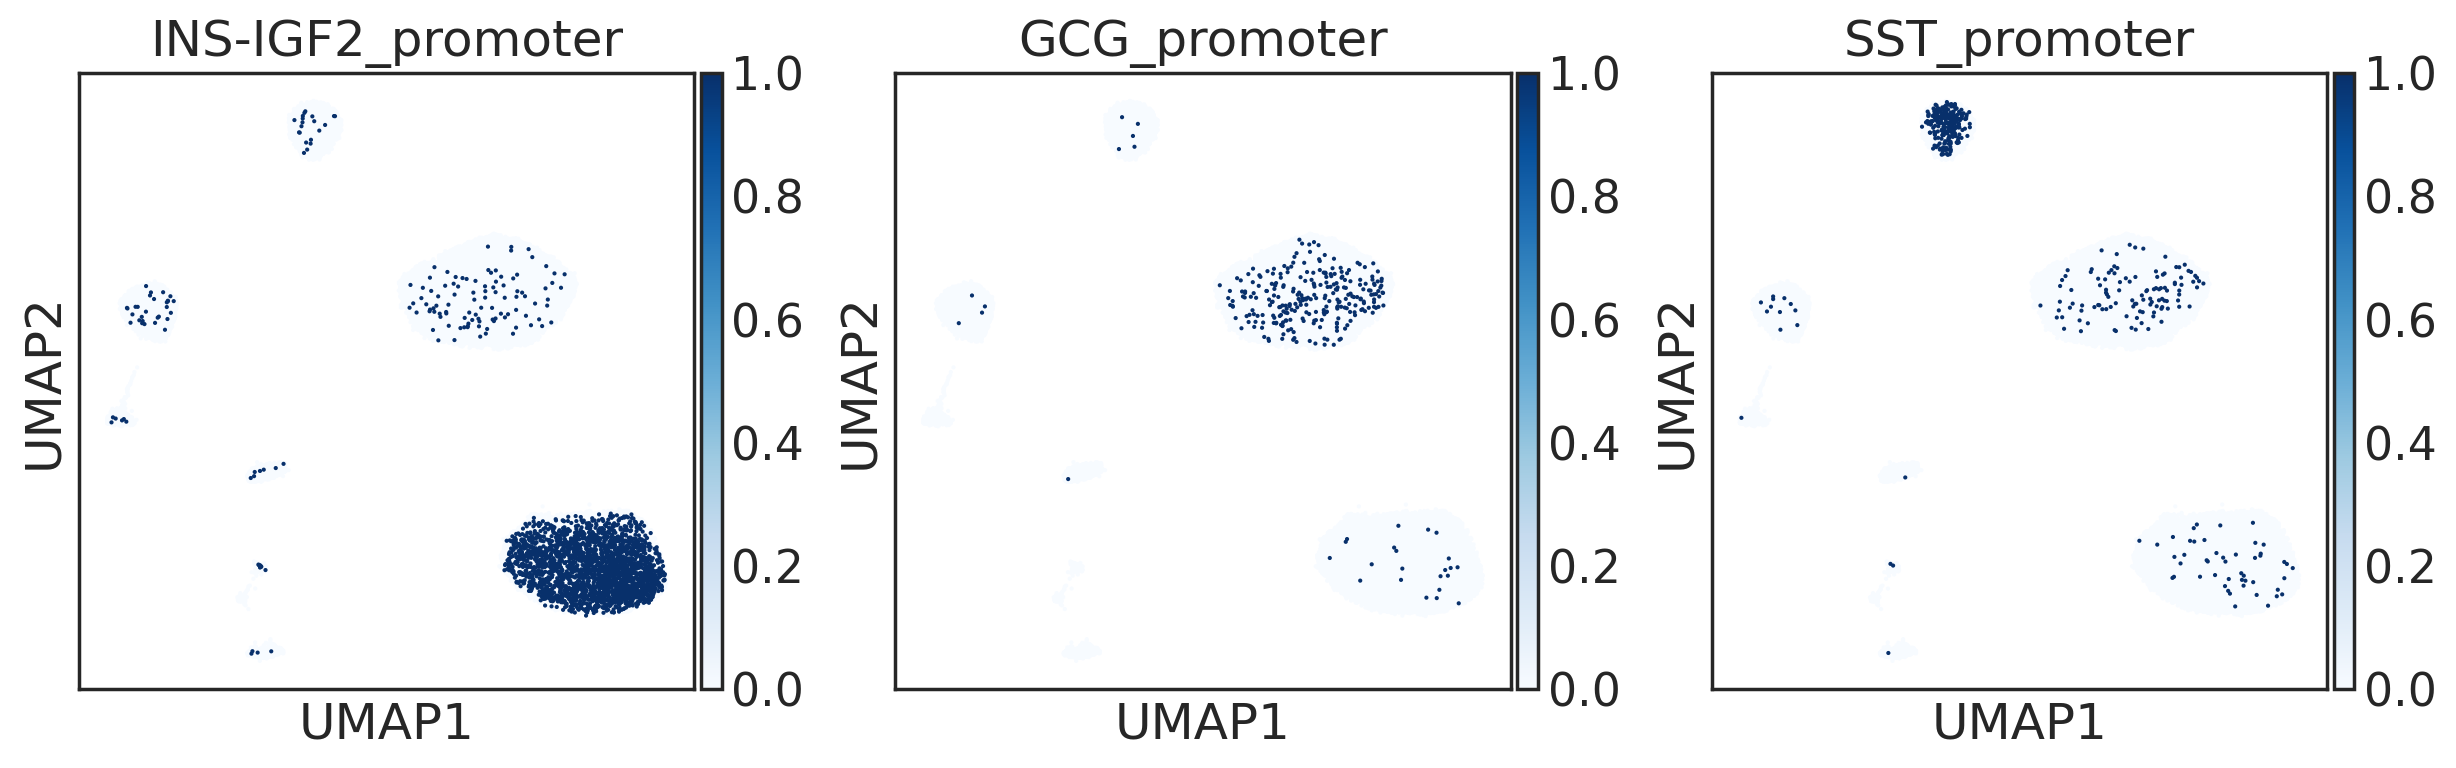

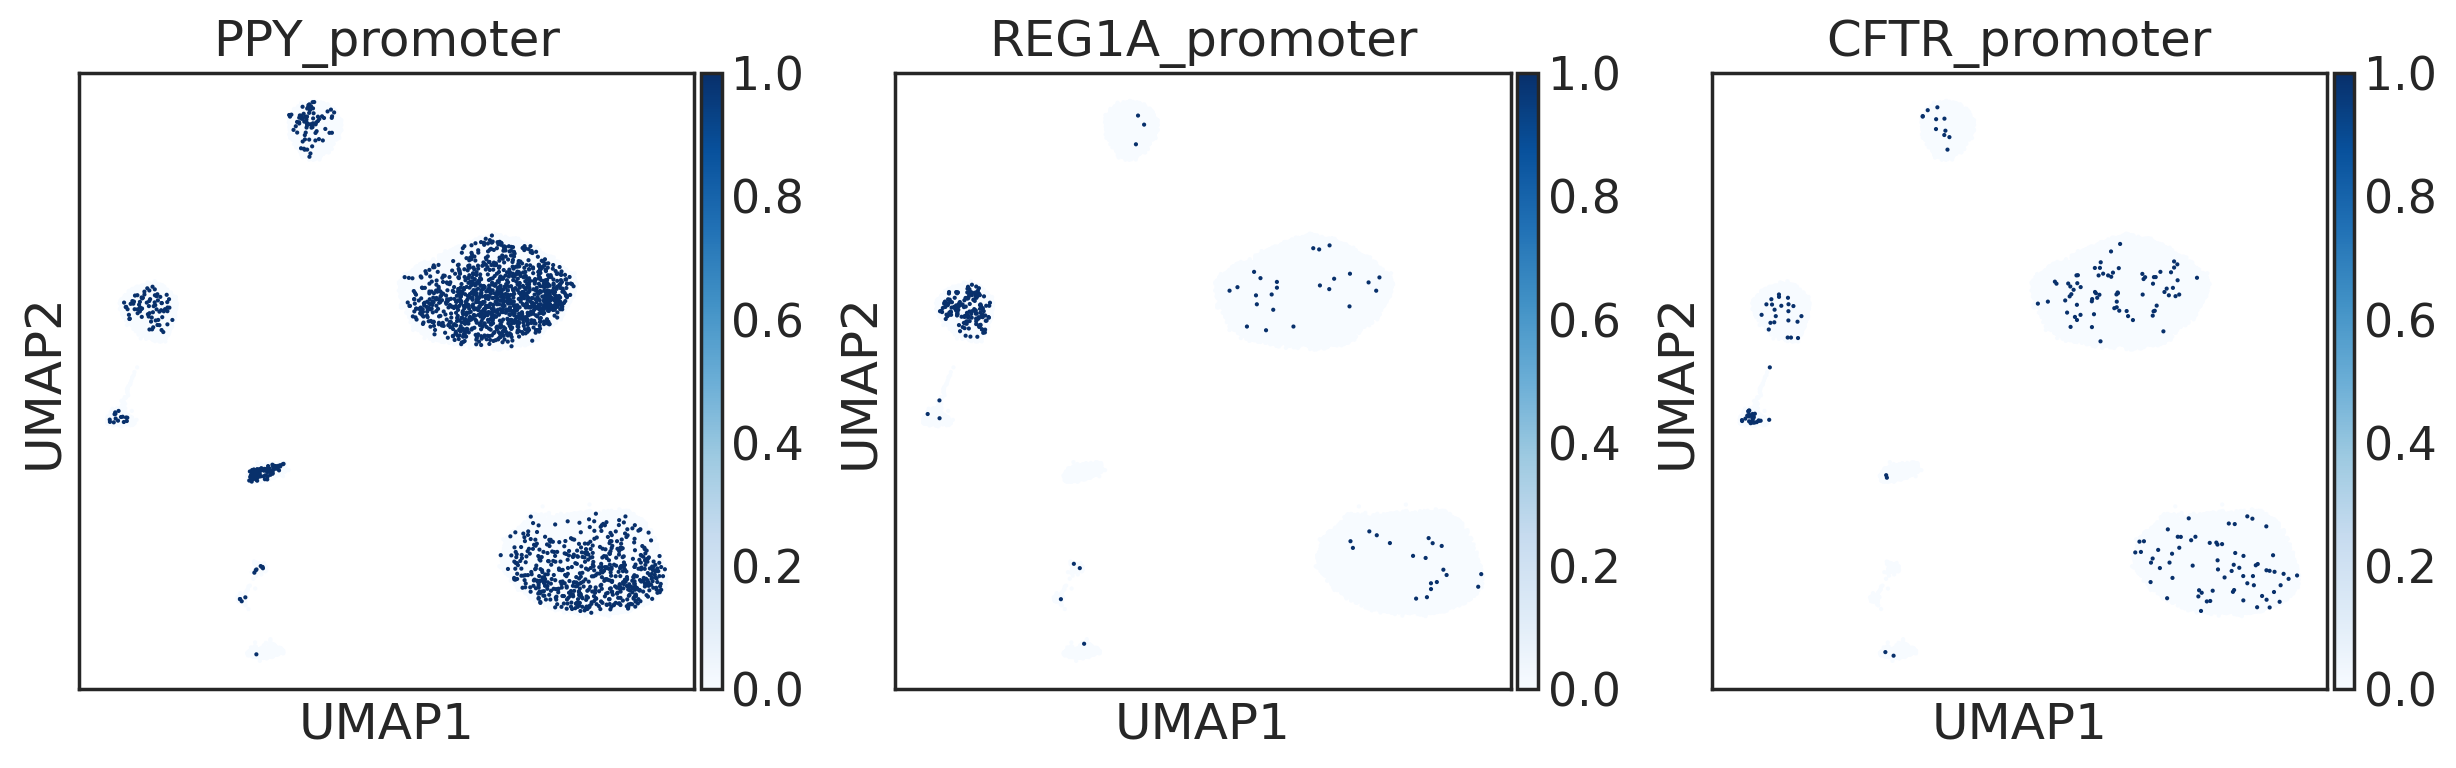

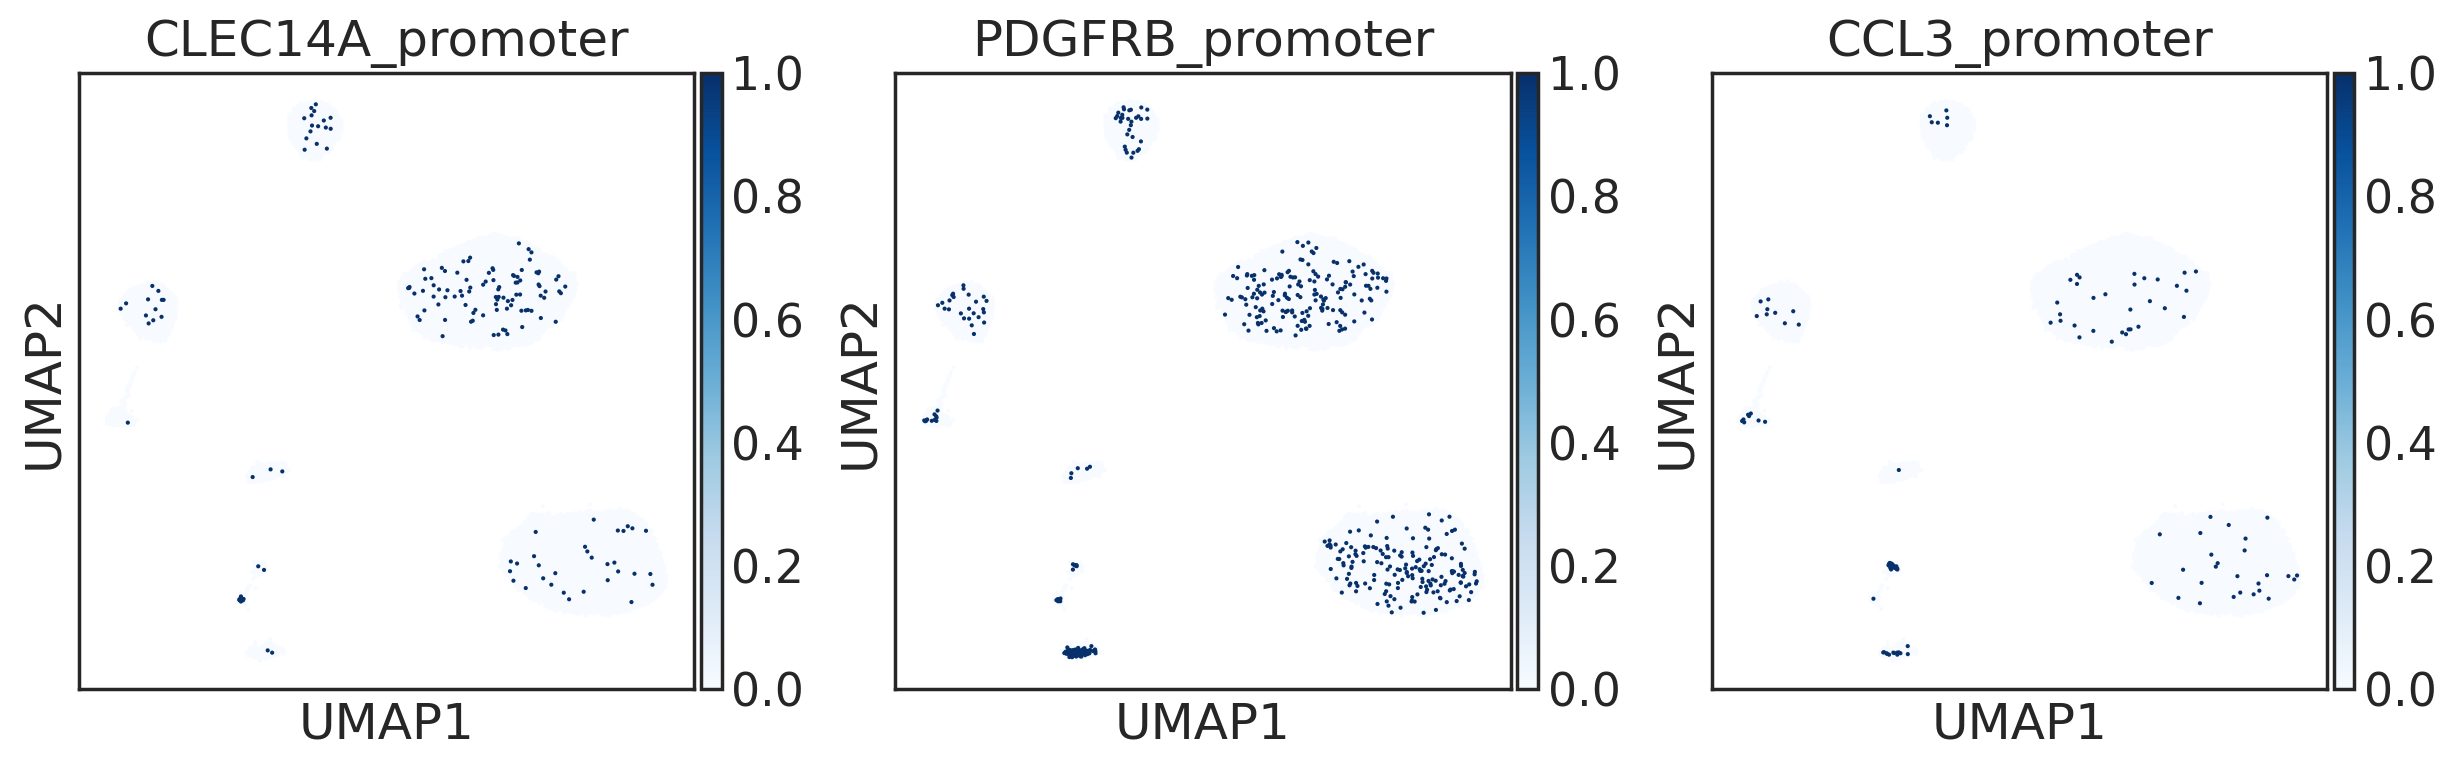

In [24]:
sc.pl.umap(adata_norm, color=['INS-IGF2_promoter','GCG_promoter','SST_promoter'], size=9, color_map='Blues', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['PPY_promoter','REG1A_promoter','CFTR_promoter'], size=9, color_map='Blues', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['CLEC14A_promoter','PDGFRB_promoter','CCL3_promoter'], size=9, color_map='Blues', frameon=True,use_raw=True)


/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


True


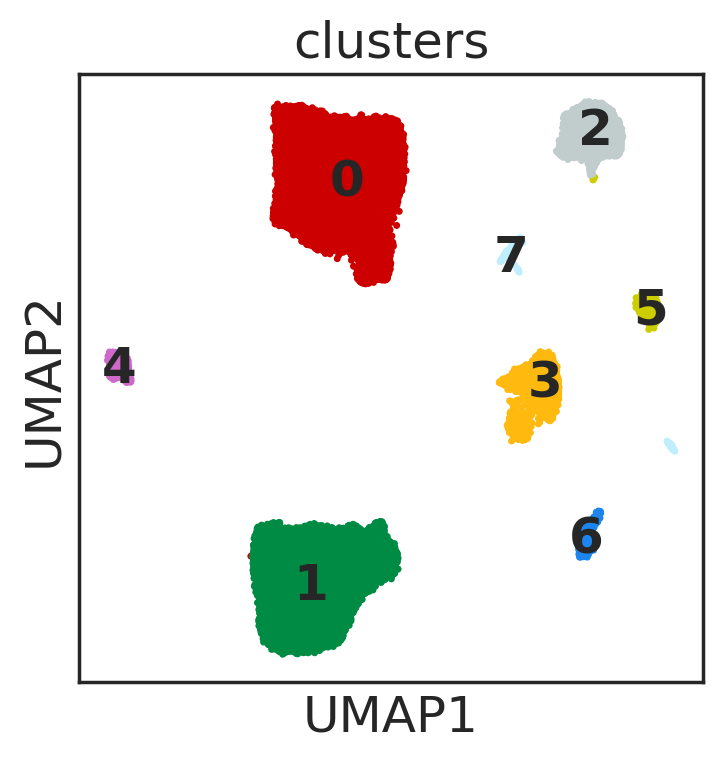

leiden
0    38298
1    33011
2     5472
3     4615
4     1331
5     1006
6      902
7      631
Name: leiden, dtype: int64

In [25]:
## RNA (Supplementary Figure 7b)
adata_norm=sc.read(wd_multiome + 'multiome_RNA_final.h5ad')
adata_RNA=sc.read(wd_multiome + 'multiome_RNA_raw.h5ad')
adata_norm.uns['leiden_colors']=['#CD0000','#008B45','#C1CDCD','#FFB90F','#CD69C9','#CDCD00','#1C86EE','#BFEFFF']

sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)
sc.pp.log1p(adata_RNA)
print(all(adata_norm.obs.index==adata_RNA.obs.index))
adata_norm.raw=adata_RNA

sc.pl.umap(adata_norm, color=['leiden'], size=25, title='clusters', legend_loc='on data')
adata_norm.obs.groupby('leiden')['leiden'].count()

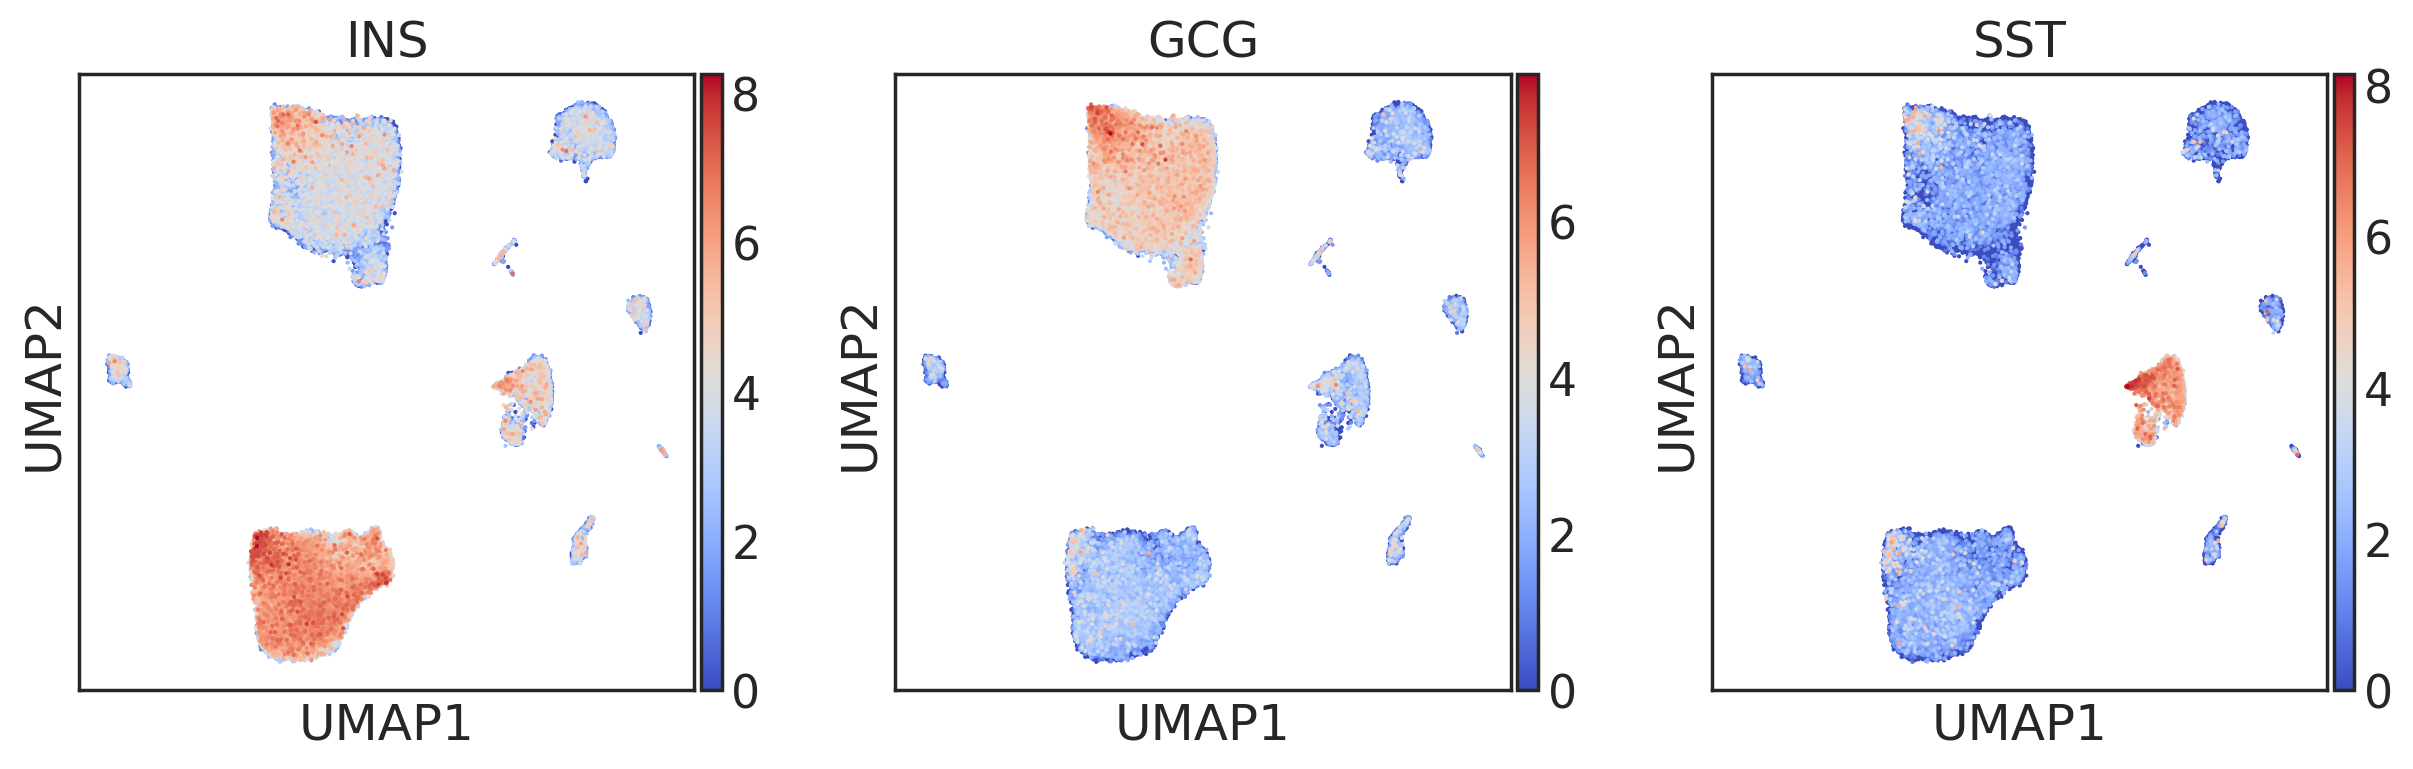

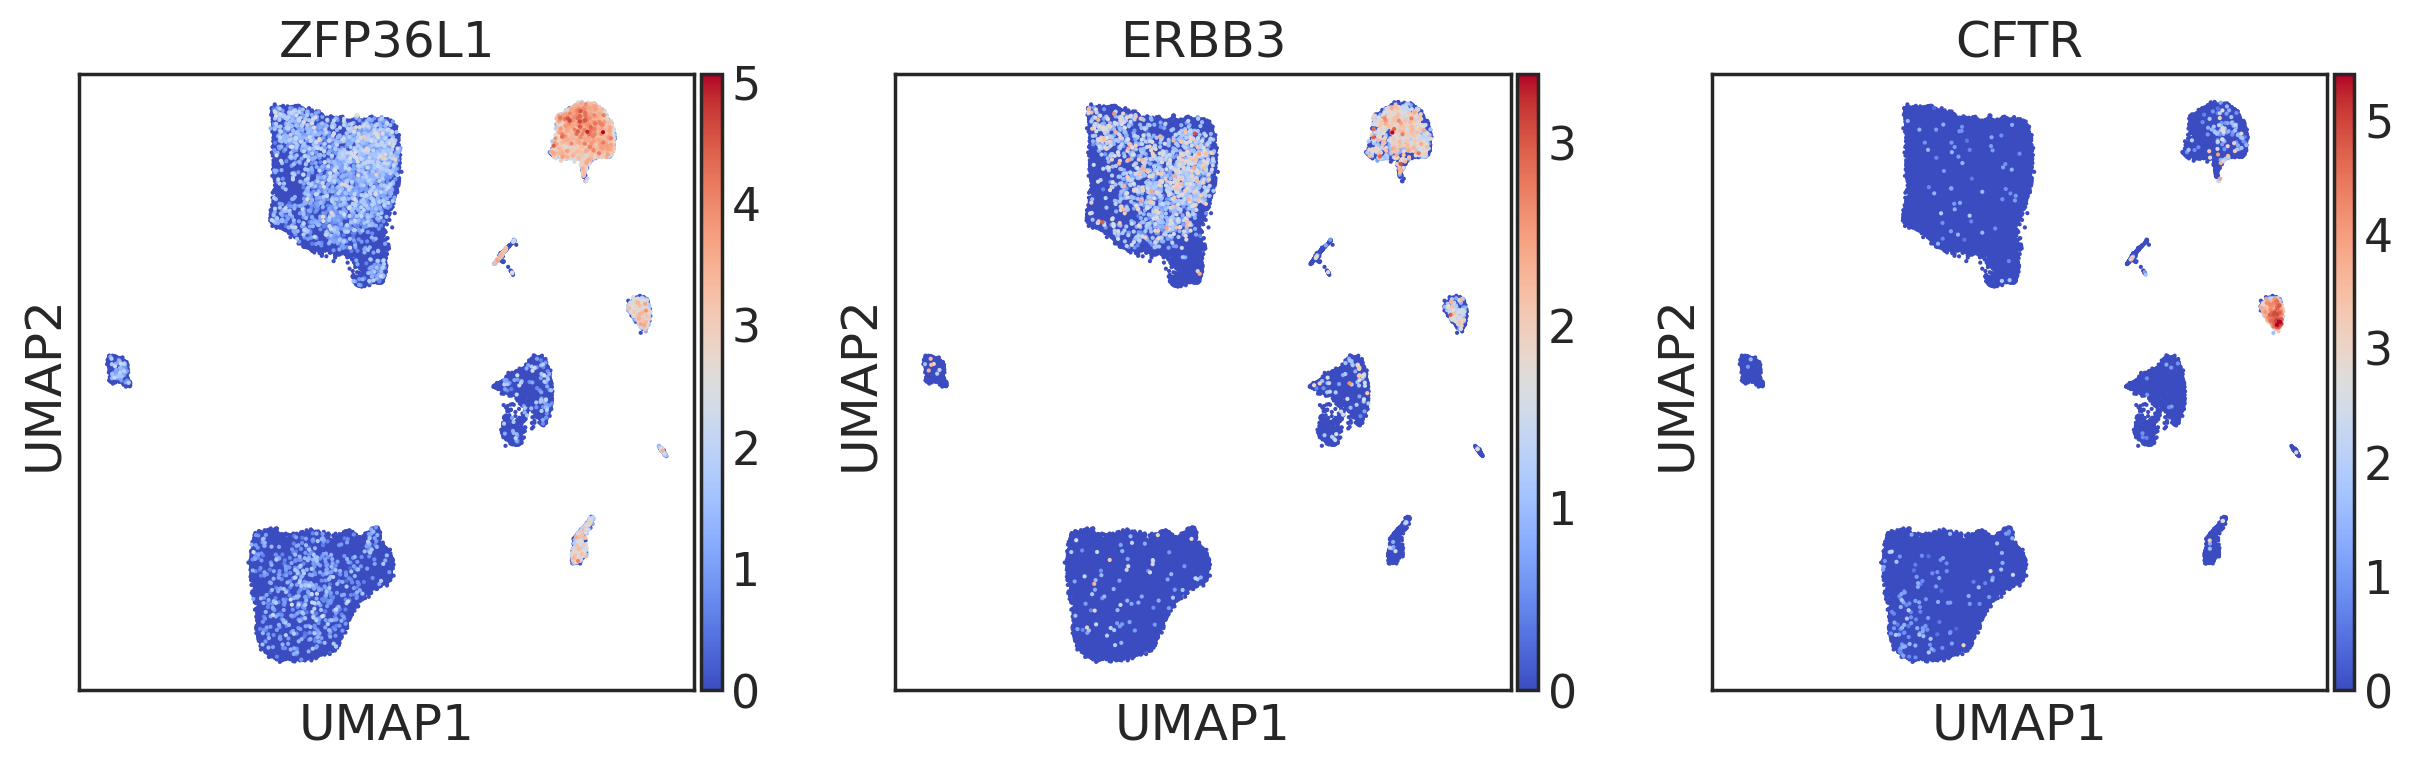

In [26]:
sc.pl.umap(adata_norm, color=['INS','GCG','SST'], size=9, color_map='coolwarm', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['ZFP36L1','ERBB3','CFTR'], size=9, color_map='coolwarm', frameon=True,use_raw=True)


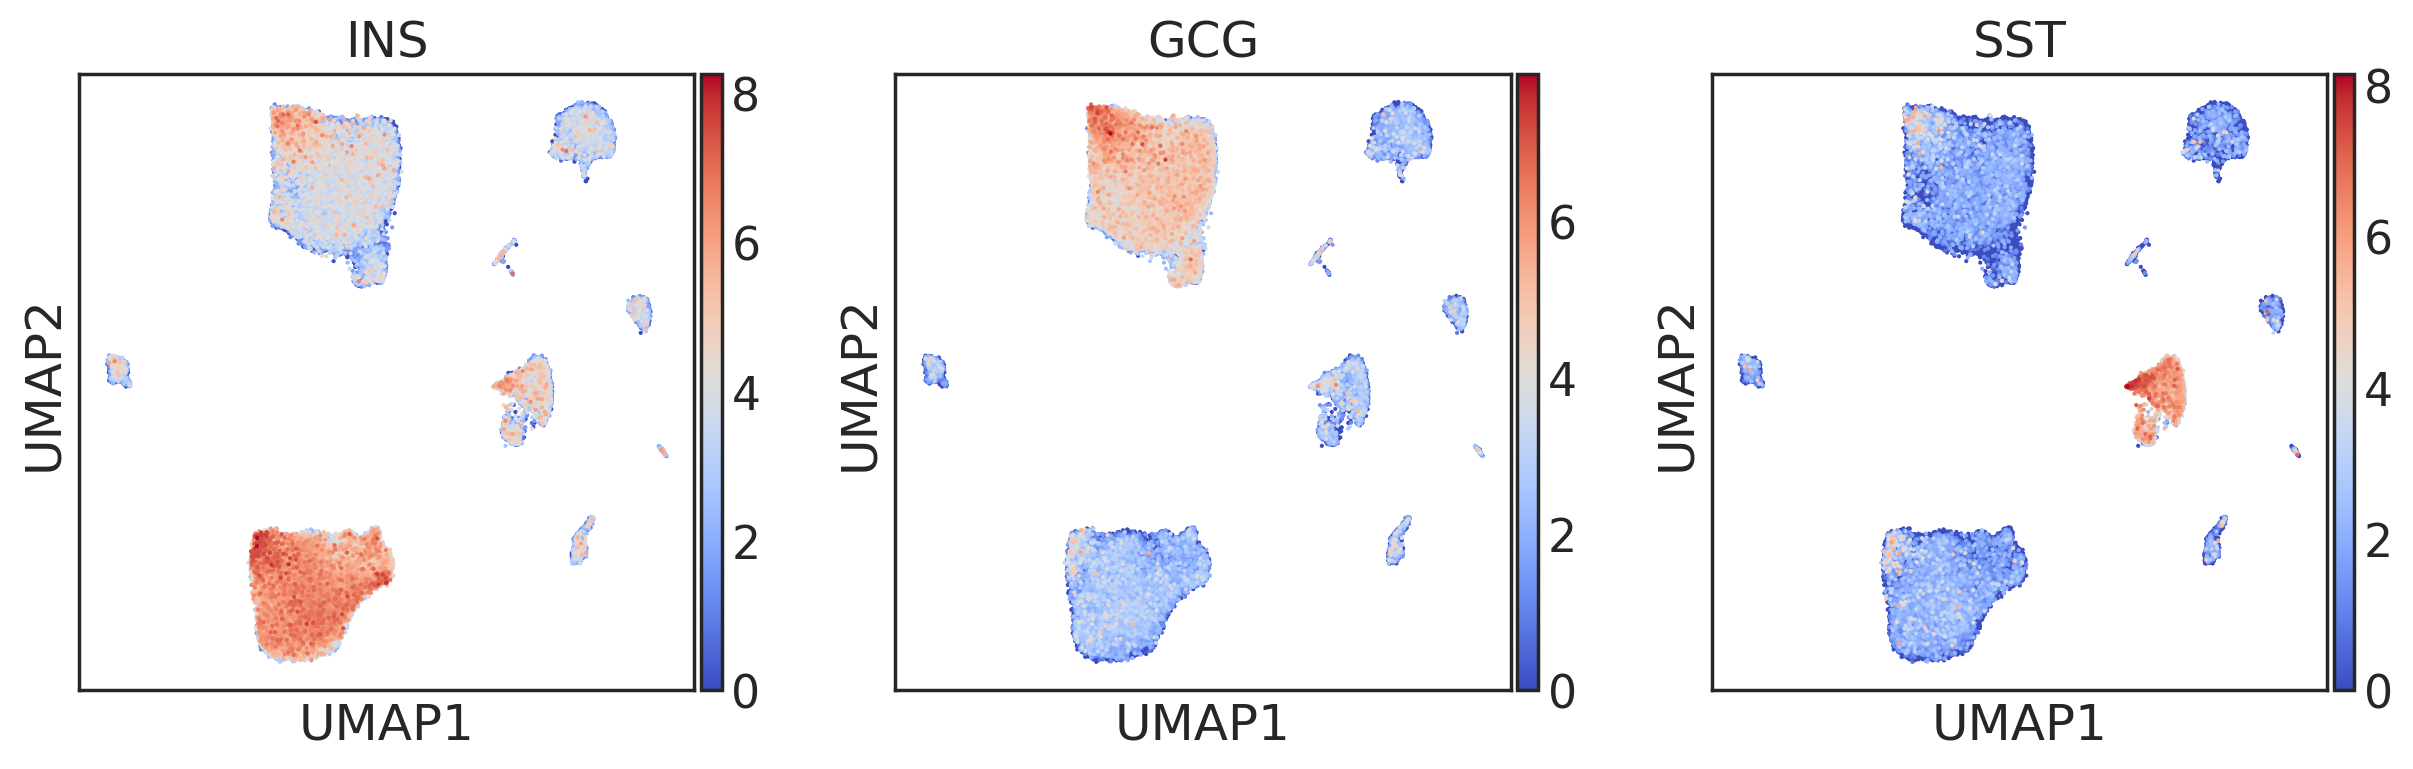

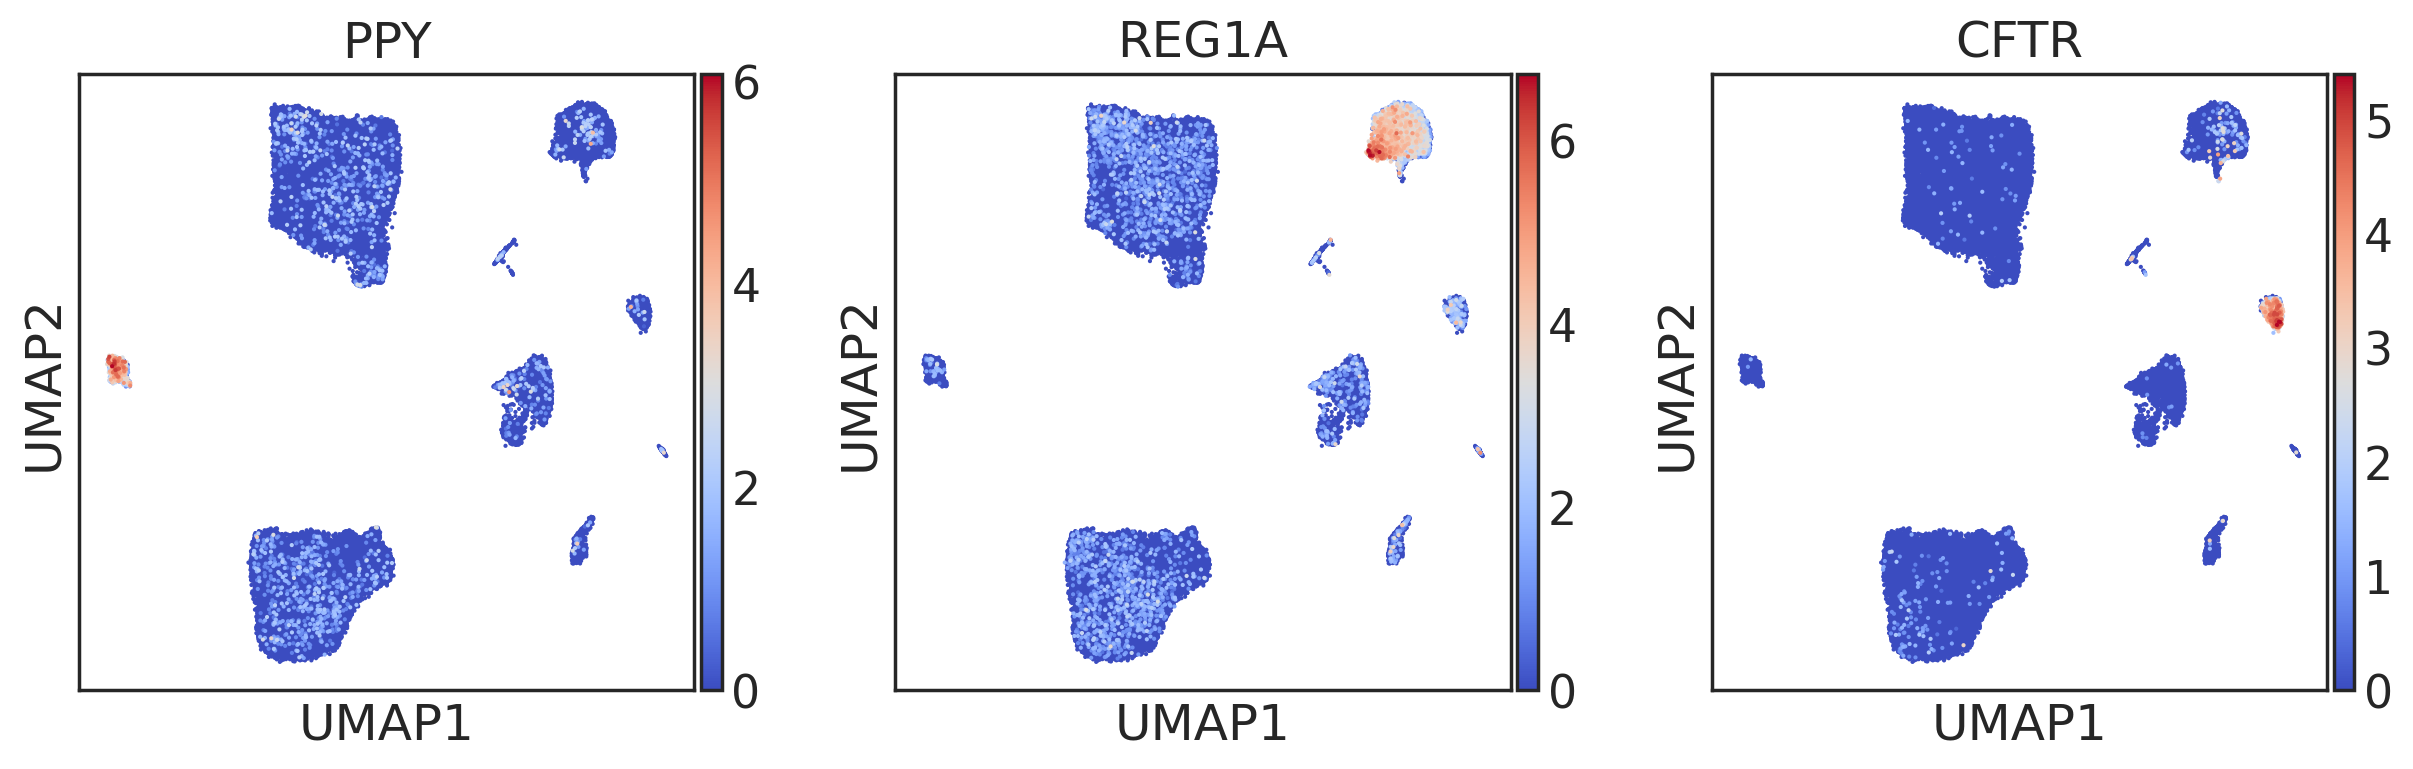

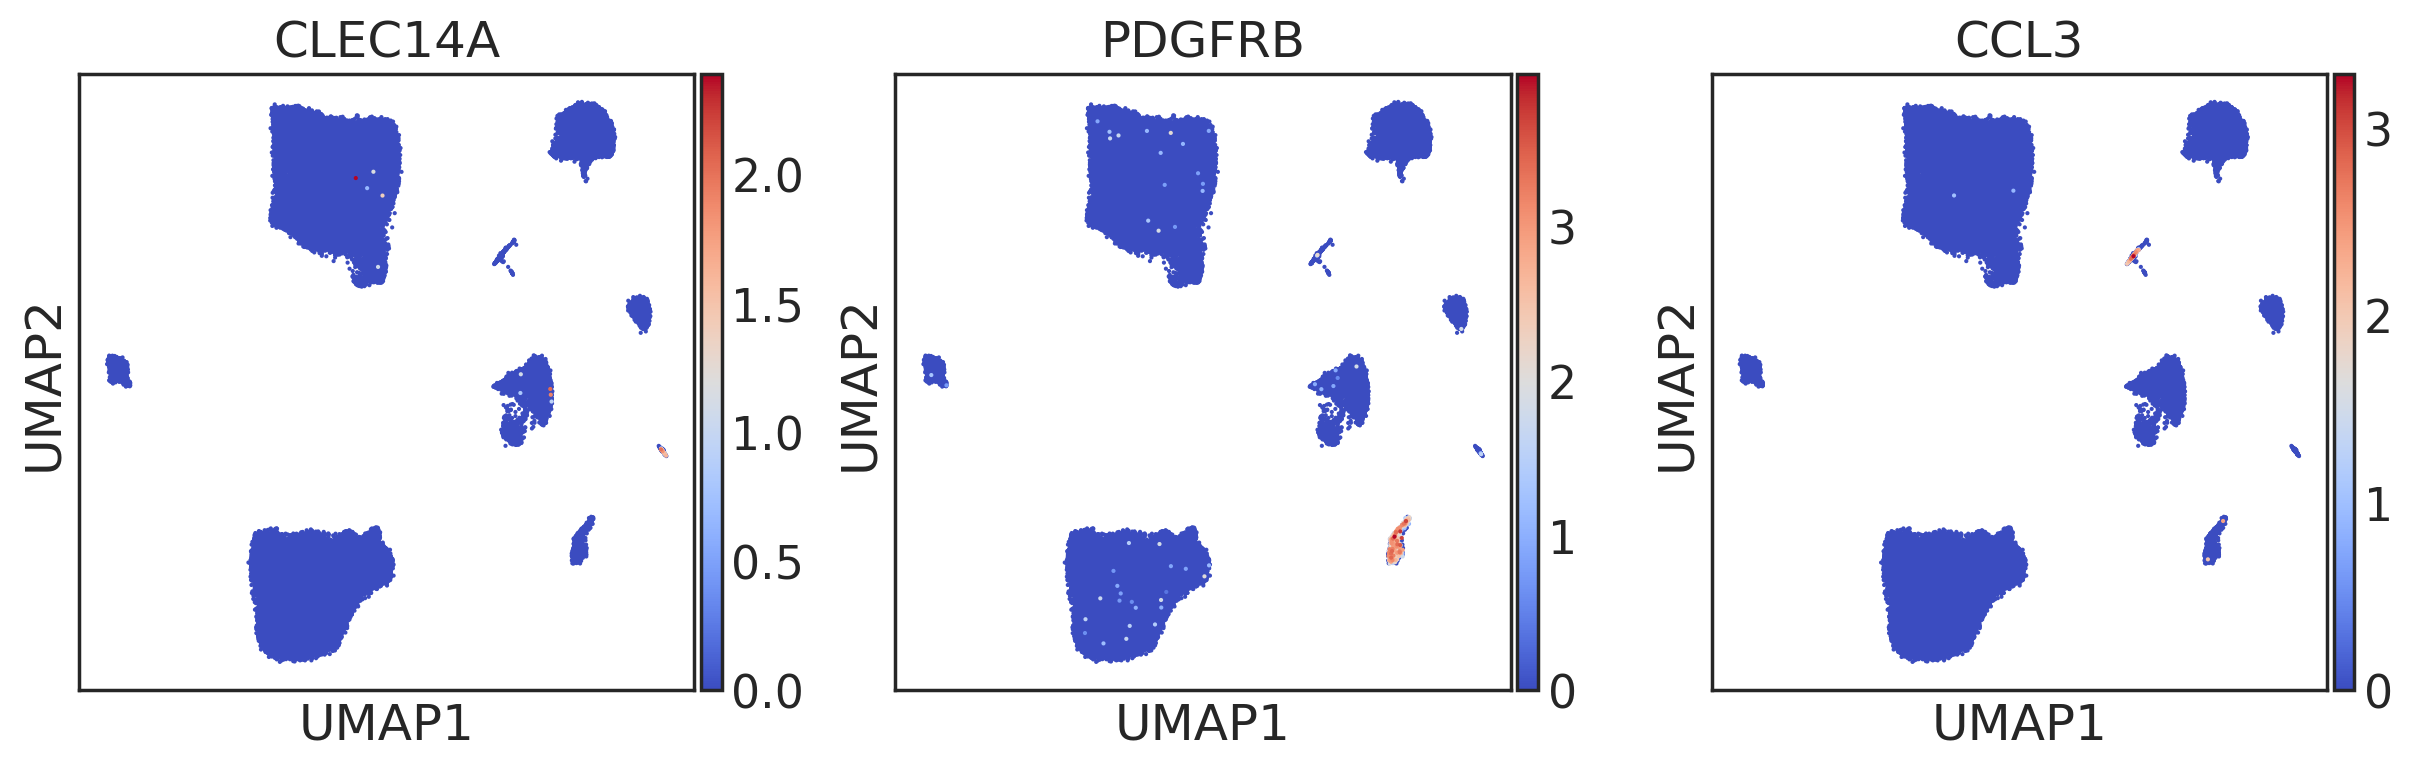

In [27]:
sc.pl.umap(adata_norm, color=['INS','GCG','SST'], size=9, color_map='coolwarm', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['PPY','REG1A','CFTR'], size=9, color_map='coolwarm', frameon=True,use_raw=True)
sc.pl.umap(adata_norm, color=['CLEC14A','PDGFRB','CCL3'], size=9, color_map='coolwarm', frameon=True,use_raw=True)


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


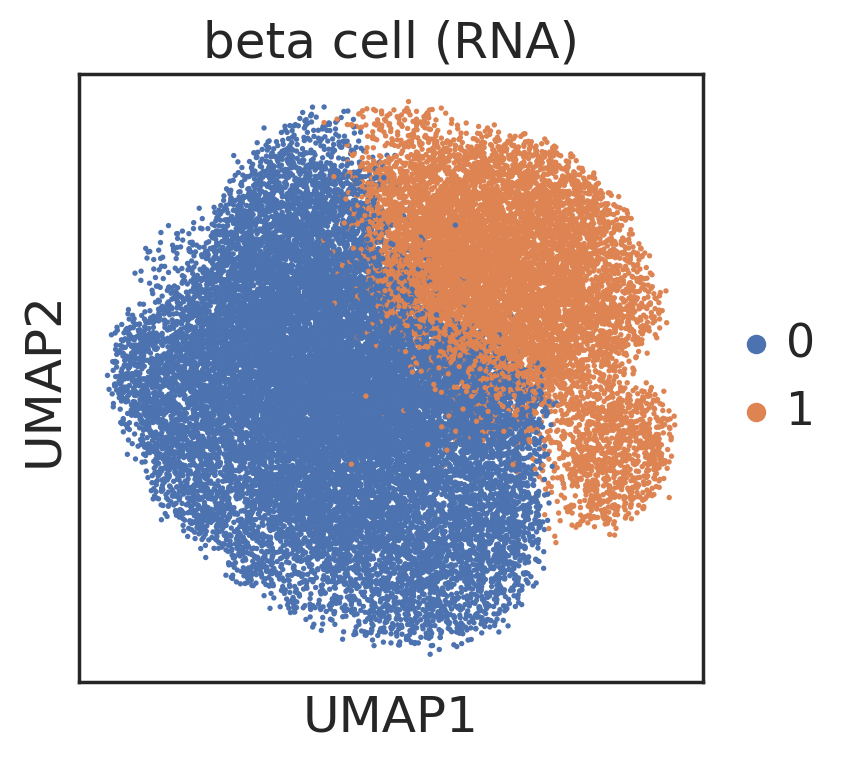

In [28]:
## RNA (Supplementary Figure 7c)
adata_norm=sc.read(wd_multiome + 'multiome_RNA_beta_final.h5ad')
adata_norm.obs['cluster']=adata_norm.obs['leiden']
sc.pl.umap(adata_norm,color=['cluster'], size=15, title='beta cell (RNA)')

/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):
/home/gaw006/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.
/home/gaw006/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])
... storing 'subtype' as categorical
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length match

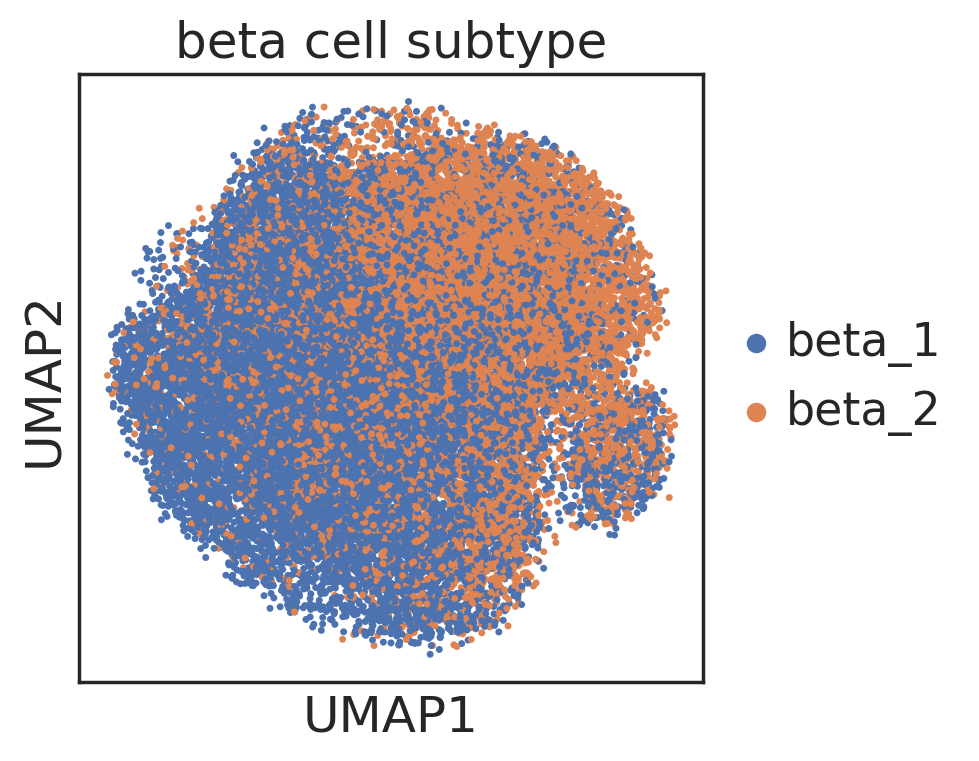

In [33]:
met = pd.read_csv(wd_multiome + 'multiome_beta_subtype.csv', sep=',', header=0, index_col=0)
met1=met.loc[met['X'].isin(adata_norm.obs.index),]
adata_norm1=adata_norm[adata_norm.obs.index.isin(met1['X']),:]
adata_norm1.obs['subtype']=met1['subtype'].tolist()
sc.pl.umap(adata_norm1, color=['subtype'], size=25, title='beta cell subtype')

# Cell cluster of Patch-seq RNA data in Supplementary Figure 8a

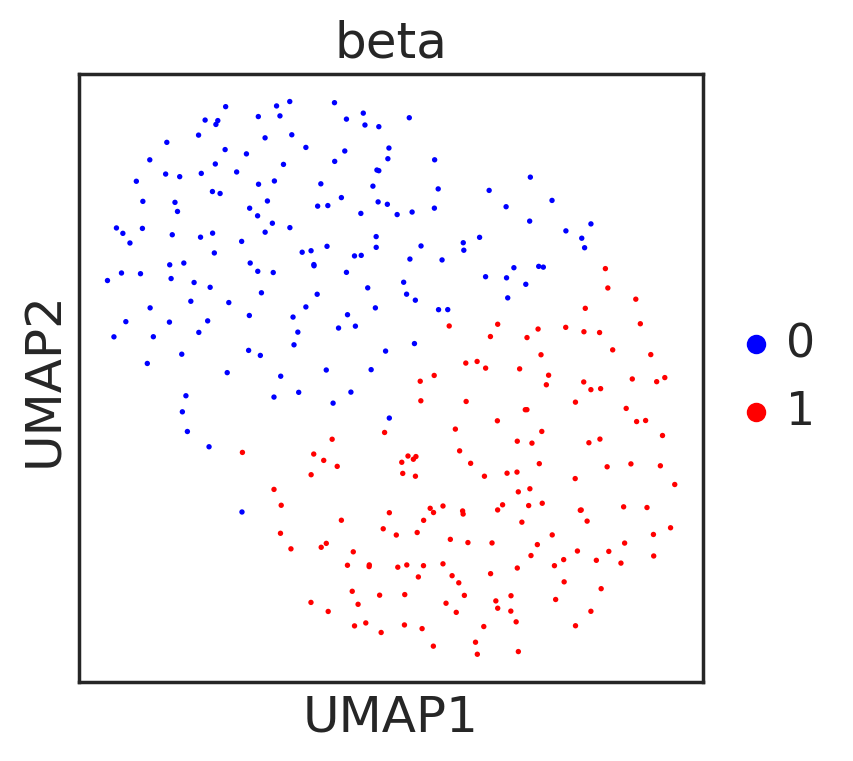

leiden
0    159
1    157
Name: leiden, dtype: int64

In [34]:
adata_norm=sc.read(wd_multiome + 'patch_beta_final.h5ad')
adata_norm.uns['leiden_colors']=['#0000FF','#FF0000']
sc.pl.umap(adata_norm,color=['leiden'], size=15, title='beta')
adata_norm.obs.groupby('leiden')['leiden'].count()